# BC1 - WWW Customer Segmentation

Andreia Bastos - m20210604 \
João Silva - m20211014 \
Pauline Richard - m20211019 \
Tiago Quaresma - m20210766

## Dataset description
#### Customer features (internal database):
- *Custid*: numeric - customer ID number 
- *Dayswus*: numeric - number of days as a customer
- *Age*: numeric - customer’s age or imputed age
- *Edu*: numeric - years of education (may be imputed)
- *Income*: numeric- household income (may be imputed)
- *Freq*: number of purchases in past 18 mo.
- *Recency*: number of days since last purchase
- *Monetary*: total sales to this person in 18 mo. 
- *LTV*: Lifetime value of the customer 
- *Perdeal*: % purchases bought on discount 
- *Dryed*:	% of wines that were dry red wines
- *Sweetred*:	% sweet or semi-dry reds
- *Drywh*:	% dry white wines 
- *Sweetwh*: % sweet or semi-dry white wines
- *Dessert*: % dessert wines (port, sherry, etc.) 
- *Exotic*:	% very unusual wines 
- *Webpurch*: % of purchases made on website 
- *Webvisit*: average # visits to website per month

In [1]:
import os
from os.path import abspath, join, pardir
from math import ceil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, precision_score, silhouette_score, silhouette_samples
#import graphviz
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

##### This has to be installed to run the RFM section
#! pip install squarify

import squarify
from scipy.cluster.hierarchy import dendrogram, linkage, set_link_color_palette
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.cluster import DBSCAN
import matplotlib.cm as cm
import sompy
from sompy.visualization.mapview import View2D
from sompy.visualization.hitmap import HitMapView

import logging
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings("ignore")

logging.getLogger('matplotlib.font_manager').disabled = True

from sklearn.manifold import TSNE

## Functions 

In [2]:
def silhuette_score(dframe,range_clusters):
    # Adapted from:
    # https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

    # Storing average silhouette metric
    avg_silhouette = []
    for nclus in range_clusters:
        # Skip nclus == 1
        if nclus == 1:
            continue
    
        # Create a figure
        fig = plt.figure(figsize=(13, 7))

        # Initialize the KMeans object with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
        cluster_labels = kmclust.fit_predict(dframe[features])

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(dframe[features], cluster_labels)
        avg_silhouette.append(silhouette_avg)
        print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(dframe[features], cluster_labels)

        y_lower = 10
        for i in range(nclus):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
        
            # Get y_upper to demarcate silhouette y range size
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
        
            # Filling the silhouette
            color = cm.nipy_spectral(float(i) / nclus)
            plt.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        plt.title("The silhouette plot for the various clusters.")
        plt.xlabel("The silhouette coefficient values")
        plt.ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
        # The silhouette coefficient can range from -1, 1
        xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
        plt.xlim([xmin, xmax])
    
        # The (nclus+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        plt.ylim([0, len(wineDf[features]) + (nclus + 1) * 10])

        plt.yticks([])  # Clear the yaxis labels / ticks
        plt.xticks(np.arange(xmin, xmax, 0.1))

In [3]:
def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    """This function computes the R2 for a set of cluster solutions given by the application of a hierarchical method.
    The R2 is a measure of the homogenity of a cluster solution. It is based on SSt = SSw + SSb and R2 = SSb/SSt. 
    
    Parameters:
    df (DataFrame): Dataset to apply clustering
    link_method (str): either "ward", "complete", "average", "single"
    max_nclus (int): maximum number of clusters to compare the methods
    min_nclus (int): minimum number of clusters to compare the methods. Defaults to 1.
    dist (str): distance to use to compute the clustering solution. Must be a valid distance. Defaults to "euclidean".
    
    Returns:
    ndarray: R2 values for the range of cluster solutions
    """
    def get_ss(df):
        ss = np.sum(df.var() * (df.count() - 1))
        return ss  # return sum of sum of squares of each df variable
    
    sst = get_ss(df)  # get total sum of squares
    
    r2 = []  # where we will store the R2 metrics for each cluster solution
    
    for i in range(min_nclus, max_nclus+1):  # iterate over desired ncluster range
        cluster = AgglomerativeClustering(n_clusters=i, affinity=dist, linkage=link_method)
        
        
        hclabels = cluster.fit_predict(df) #get cluster labels
        
        
        df_concat = pd.concat((df, pd.Series(hclabels, name='labels')), axis=1)  # concat df with labels
        
        
        ssw_labels = df_concat.groupby(by='labels').apply(get_ss)  # compute ssw for each cluster labels
        
        
        ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
        
        
        r2.append(ssb / sst)  # save the R2 of the given cluster solution
        
    return np.array(r2)

In [4]:
# find optimal number of clusters 

def do_dendogram(hclust,linkage):
    # Adapted from:
    # https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

    # create the counts of samples under each node (number of points being merged)
    counts = np.zeros(hclust.children_.shape[0])
    n_samples = len(hclust.labels_)

    # hclust.children_ contains the observation ids that are being merged together
    # At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
    for i, merge in enumerate(hclust.children_):
        # track the number of observations in the current cluster being formed
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                # If this is True, then we are merging an observation
                current_count += 1  # leaf node
            else:
                # Otherwise, we are merging a previously formed cluster
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    # the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
    # the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
    # the counts indicate the number of points being merged (dendrogram's x-axis)
    linkage_matrix = np.column_stack(
        [hclust.children_, hclust.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    sns.set()
    fig = plt.figure(figsize=(11,5))
    # The Dendrogram parameters need to be tuned
    y_threshold = 100
    dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
    plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
    plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
    plt.xlabel('Number of points in node (or index of point if no parenthesis)')
    plt.ylabel(f'{distance.title()} Distance', fontsize=13)
    plt.show()

In [5]:
#Function to calculate the R^2
def r2(df, names, label):
    def get_ss(df):
        ss = np.sum(df.var() * (df.count() - 1))
        return ss
    sst = get_ss(df[names])  # get total sum of squares
    ssw_labels = df[names + [label]].groupby(by=label).apply(get_ss)  # compute ssw for each cluster labels
    ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
    r2 = ssb / sst
    return r2

In [6]:
def find_hc_method(df,features):
    # Prepare input
    hc_methods = ["ward", "complete", "average", "single"]
    # Call function defined above to obtain the R2 statistic for each hc_method
    max_nclus = 10
    r2_hc_methods = np.vstack(
    [
        get_r2_hc(df=df[features], link_method=link, max_nclus=max_nclus) 
        for link in hc_methods
    ]
    ).T
    r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)

    sns.set()
    # Plot data
    fig = plt.figure(figsize=(11,5))
    sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

    # Finalize the plot
    fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
    plt.gca().invert_xaxis()  # invert x axis
    plt.legend(title="HC methods", title_fontsize=11)
    plt.xticks(range(1, max_nclus + 1))
    plt.xlabel("Number of clusters", fontsize=13)
    plt.ylabel("R2 metric", fontsize=13)

    plt.show()

In [153]:
#scale both new dataframes
def scale_minMax(df,features):
    df_minmax = df.copy()
    scaler = MinMaxScaler()
    df_minmax[features] = scaler.fit_transform(df_minmax[features])
    return df_minmax

In [8]:
def kmeans_elbow(df, name):
    distortions = []
    K = range(1,11)
    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(df)
        distortions.append(kmeanModel.inertia_)
    plt.figure(figsize=(16,8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for the customer ' + name + 'view ')
    plt.show()

In [9]:
def kmeans_hierarchical(df, name): 
    kmeans = KMeans(
    init='k-means++',
    n_init=20,
    random_state=42
    )
    kmeans.fit_predict(df)
    distance = 'Euclidean'
    # Adapted from:
    # https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

    # create the counts of samples under each node (number of points being merged)
    cen = kmeans.cluster_centers_

    Z = linkage(cen, method = 'ward') 
    # Plot the corresponding dendrogram
    sns.set()
    fig = plt.figure(figsize=(11,5))
    # The Dendrogram parameters need to be tuned
    dendrogram(Z, truncate_mode='level', p=5)
    #plt.hlines(100, 0, 1000, colors="r", linestyles="dashed")
    plt.title(f'Hierarchical Clustering -'+name+'Dendrogram', fontsize=10)
    plt.xlabel('Number of points in node (or index of point if no parenthesis)')
    plt.ylabel(f'{distance.title()} Distance', fontsize=10)
    plt.show()

In [10]:
def apply_kmeans(df,df_main,df_scaled,n_clust,view):
    kmeans = KMeans(
    n_clusters=n_clust,
    init='k-means++',
    n_init=20,
    random_state=42
)
    kmeans_labels= kmeans.fit_predict(df_scaled)

    df['kmeans_labels'] = kmeans_labels
    df_main['kmeans_labels_'+view] = kmeans_labels


In [11]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        test,_ = ['Economic Wine Explorers','Champions','Dry Red Lovers'],ax[0].get_legend_handles_labels()
        cluster_labels = ["{}".format(test[i]) for i in range(len(test))]
        ax[0].annotate(s=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(test)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(test)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

## Load the data

In [236]:
wineDf = pd.read_excel("data/WonderfulWinesoftheWorld.xlsx")

## Description of the data

In [13]:
wineDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Custid       10000 non-null  float64
 1   Dayswus      10001 non-null  float64
 2   Age          10001 non-null  float64
 3   Edu          10001 non-null  float64
 4   Income       10001 non-null  float64
 5   Freq         10001 non-null  float64
 6   Recency      10001 non-null  float64
 7   Monetary     10001 non-null  float64
 8   LTV          10001 non-null  float64
 9   Perdeal      10001 non-null  float64
 10  Dryred       10001 non-null  float64
 11  Sweetred     10001 non-null  float64
 12  Drywh        10001 non-null  float64
 13  Sweetwh      10001 non-null  float64
 14  Dessert      10001 non-null  float64
 15  Exotic       10001 non-null  float64
 16  WebPurchase  10001 non-null  float64
 17  WebVisit     10001 non-null  float64
dtypes: float64(18)
memory usage: 1.4 MB


In [237]:
wineDf.describe(include='all').transpose()

count        mean           std      min       25%      50%  \
Custid       10000.0   6000.5000   2886.895680   1001.0   3500.75   6000.5   
Dayswus      10001.0    898.1020    202.482664    550.0    724.00    894.0   
Age          10001.0     47.9273     17.301856     18.0     33.00     48.0   
Edu          10001.0     16.7391      1.876281     12.0     15.00     17.0   
Income       10001.0  69904.3580  27610.852665  10000.0  47646.00  70009.0   
Freq         10001.0     14.6281     11.968475      1.0      4.00     12.0   
Recency      10001.0     62.4068     69.870762      0.0     26.00     52.0   
Monetary     10001.0    622.5552    647.102966      6.0     63.00    383.0   
LTV          10001.0    209.0712    291.971441   -178.0     -2.00     57.0   
Perdeal      10001.0     32.3972     27.895699      0.0      6.00     25.0   
Dryred       10001.0     50.3827     23.452643      1.0     32.00     51.0   
Sweetred     10001.0      7.0545      7.866151      0.0      2.00      4.0   
Drywh        10001.0     28.5213     12.583328      1.0     19.00     28.0   
Sweetwh      10001.0      7.0698      8.014682      0.0      2.00      4.0   
Dessert      10001.0      6.9474      7.879152      0.0      2.00      4.0   
Exotic       10001.0     16.5466     17.246809      0.0      4.00     10.0   
WebPurchase  10001.0     42.3762     18.521136      4.0     28.00     45.0   
WebVisit     10001.0      5.2166      2.330340      0.0      3.00      6.0   

                  75%       max  
Custid        8500.25   11000.0  
Dayswus       1074.00    1250.0  
Age             63.00      78.0  
Edu             18.00      20.0  
Income       92147.00  140628.0  
Freq            24.00      56.0  
Recency         78.00     549.0  
Monetary      1077.00    3052.0  
LTV            364.00    1791.0  
Perdeal         56.00      97.0  
Dryred          69.00      99.0  
Sweetred        10.00      75.0  
Drywh           37.00      74.0  
Sweetwh         10.00      62.0  
Dessert          9.00      77.0  
Exotic          23.00      96.0  
WebPurchase     57.00      88.0  
WebVisit         7.00      10.0

In [238]:
features = wineDf.columns.to_list()
features.remove('Custid')

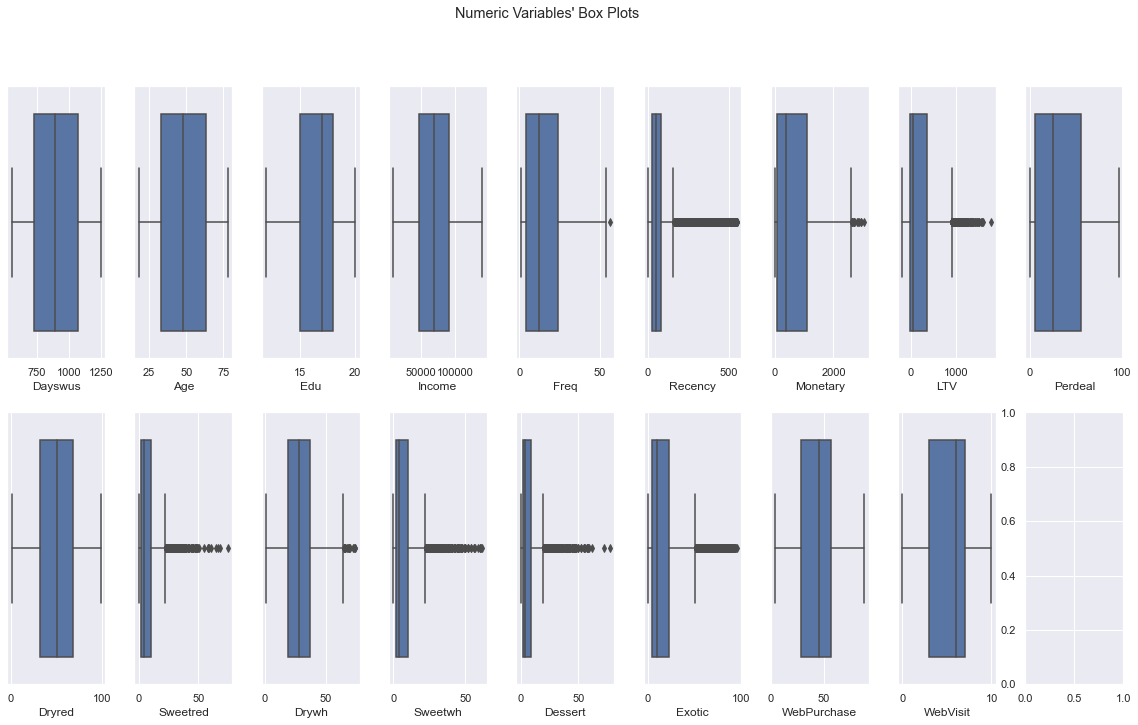

In [17]:
# All Numeric Variables' Box Plots in one figure
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot:
for ax, feat in zip(axes.flatten(), features):
    sns.boxplot(x=wineDf[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"
plt.suptitle(title)
plt.subplots_adjust(wspace=0.3)

plt.show()

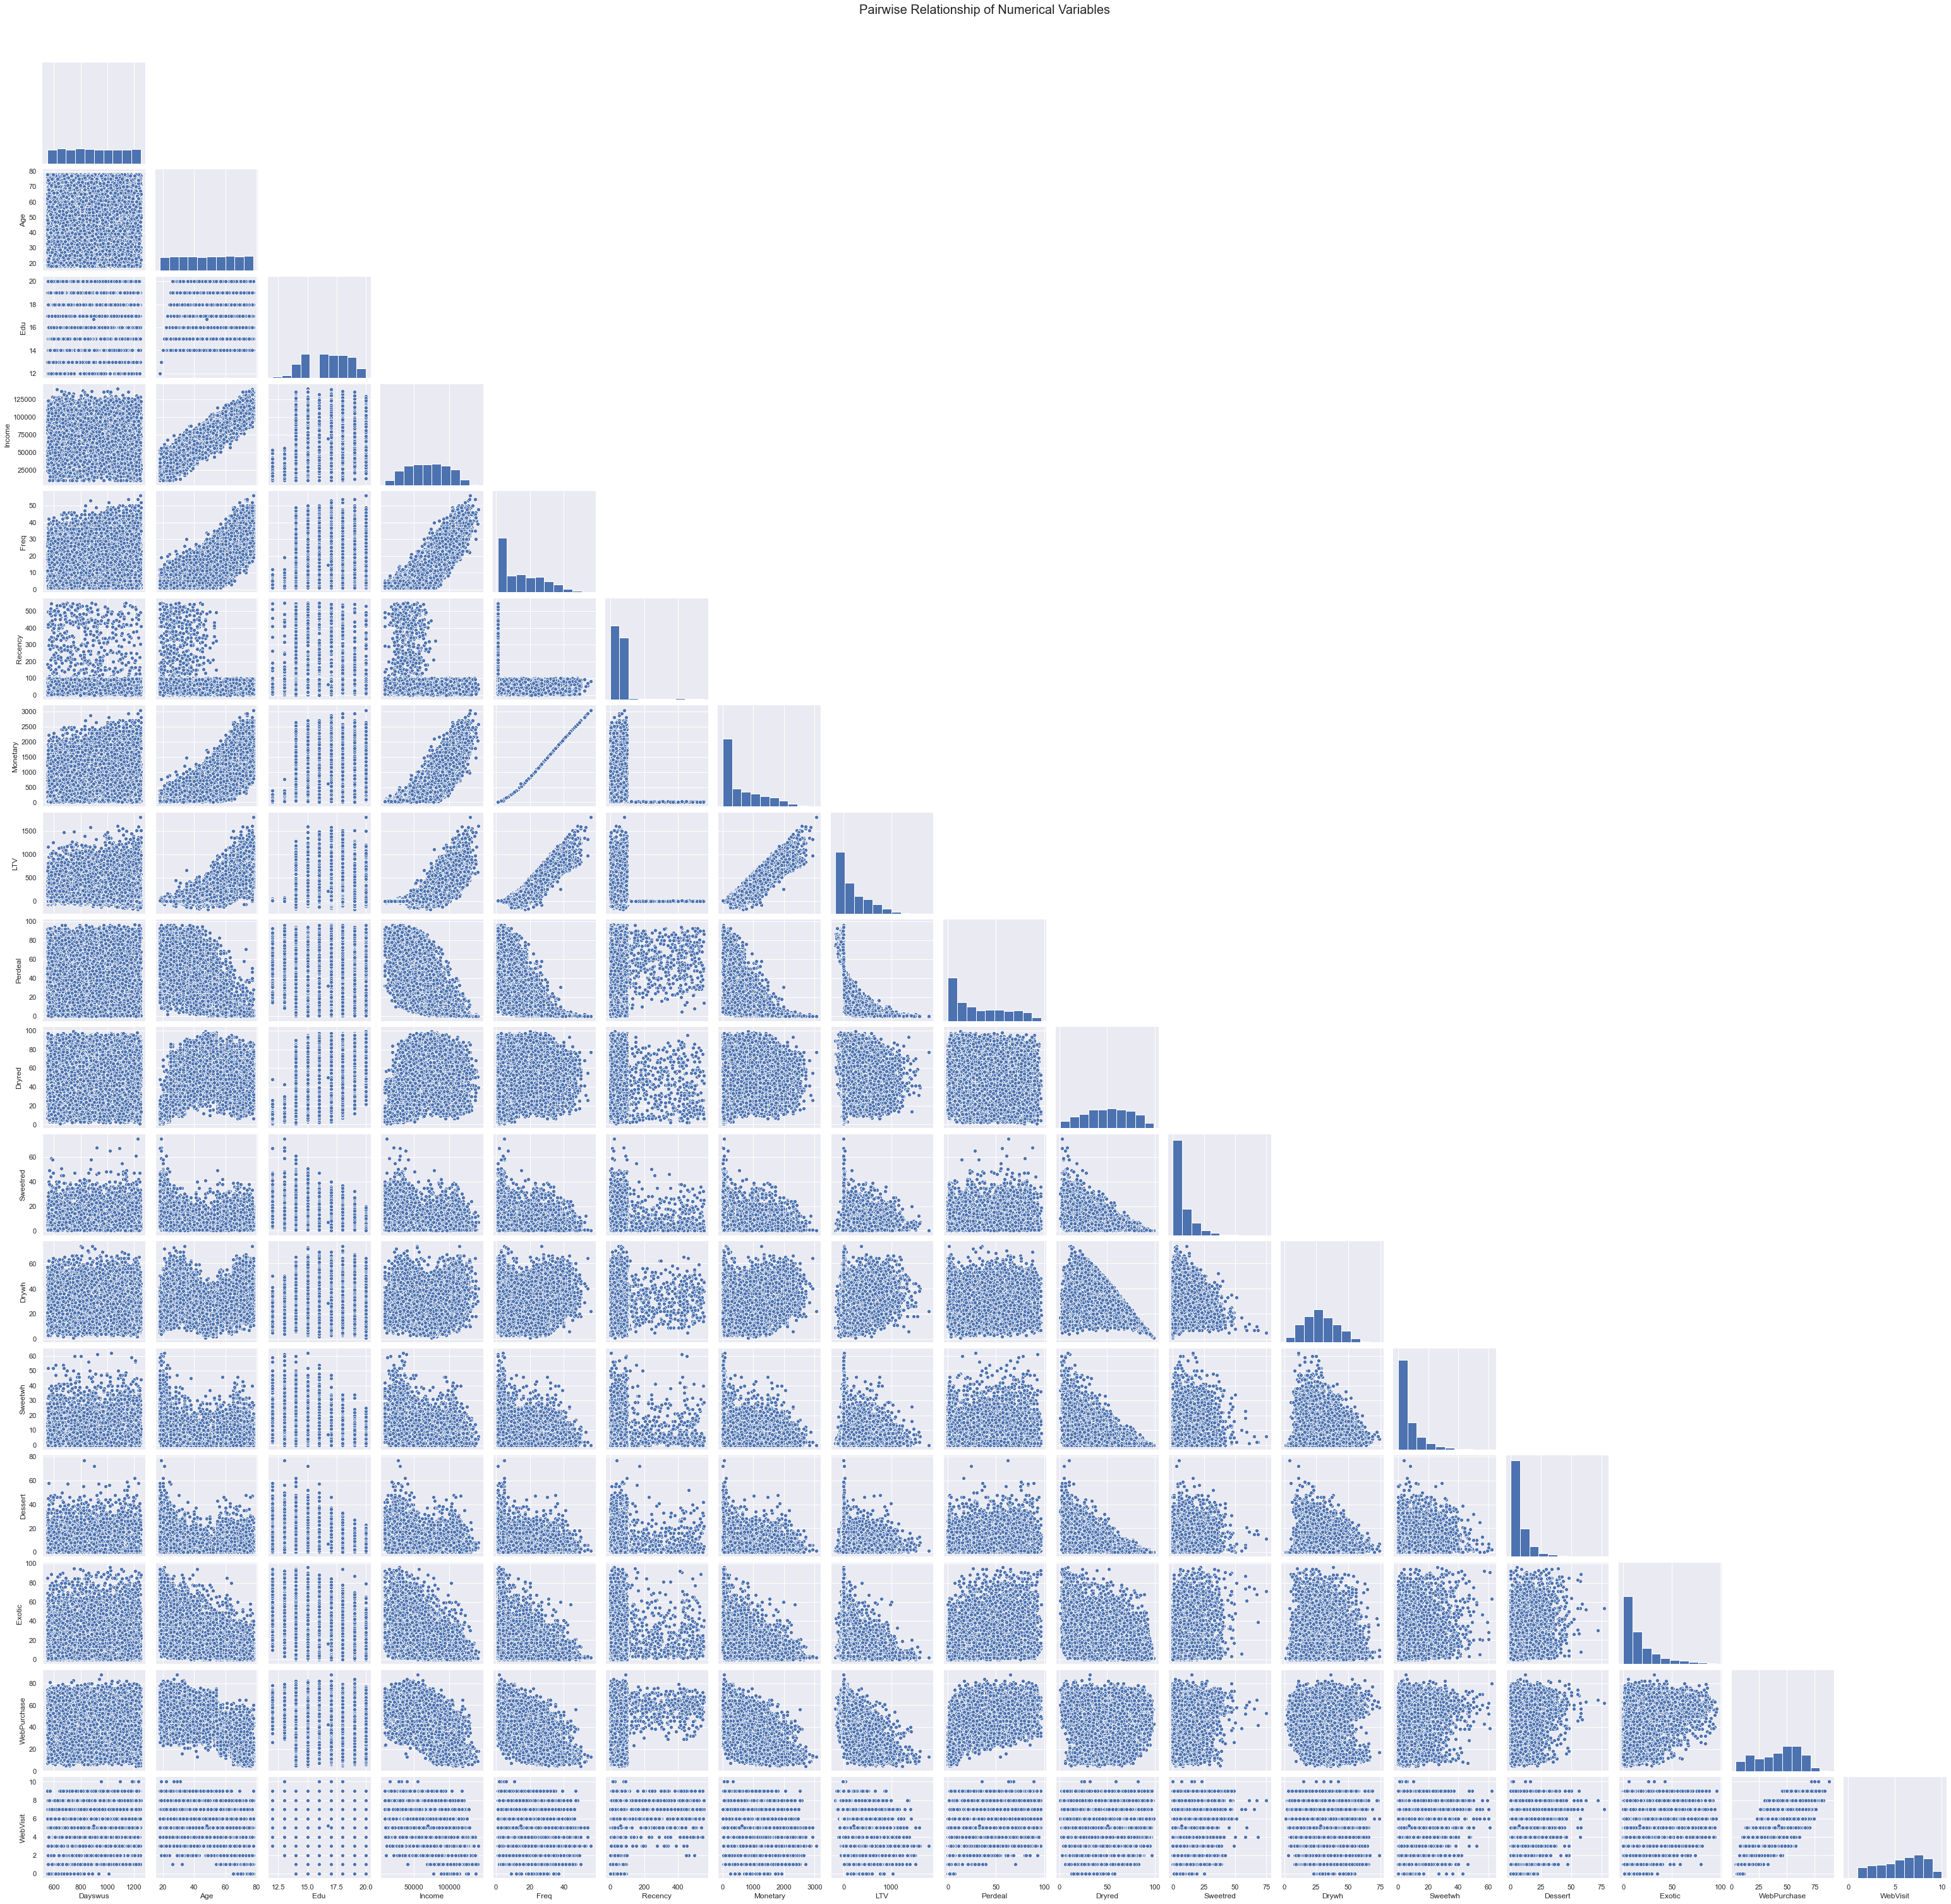

In [18]:
# Pairwise Relationship of Numerical Variables
sns.set()

# Setting pairplot
sns.pairplot(wineDf[features], diag_kind="hist", corner = True)

# Layout
plt.subplots_adjust(top=0.95)
plt.suptitle("Pairwise Relationship of Numerical Variables", fontsize=20)
plt.show()

## Coherence Check

In [239]:
wineDf[wineDf['Age'] < 21 ]

Custid  Dayswus   Age   Edu   Income  Freq  Recency  Monetary   LTV  \
2      3681.0    666.0  18.0  12.0  27984.0   4.0     56.0      39.0  -7.0   
34     4324.0    870.0  20.0  14.0  28393.0   1.0    243.0      13.0  -1.0   
46     4274.0    655.0  19.0  13.0  33631.0   3.0     36.0      38.0  -2.0   
75     5172.0   1139.0  20.0  14.0  24036.0   4.0     41.0      89.0  -7.0   
81     8146.0   1167.0  20.0  14.0  50293.0   9.0     69.0     256.0   3.0   
...       ...      ...   ...   ...      ...   ...      ...       ...   ...   
9885  10042.0    720.0  20.0  14.0  20957.0   5.0     31.0      44.0  -3.0   
9922   9499.0    974.0  20.0  14.0  10000.0   4.0     31.0      35.0  -7.0   
9927   4898.0   1091.0  19.0  13.0  56273.0  10.0     42.0     306.0  48.0   
9964   5957.0   1217.0  19.0  13.0  18298.0   2.0     43.0      32.0  -3.0   
9997   7909.0    619.0  18.0  12.0  40466.0   3.0     65.0      47.0   5.0   

      Perdeal  Dryred  Sweetred  Drywh  Sweetwh  Dessert  Exotic  WebPurchase  \
2        88.0     4.0      29.0   14.0     32.0     21.0    48.0         60.0   
34       62.0     7.0      50.0    8.0     34.0      0.0    48.0         44.0   
46       66.0    12.0      25.0   34.0     23.0      6.0    23.0         42.0   
75       69.0    11.0      13.0   43.0     15.0     17.0    31.0         67.0   
81       48.0     7.0      22.0   32.0     21.0     18.0    47.0         66.0   
...       ...     ...       ...    ...      ...      ...     ...          ...   
9885     70.0     8.0      12.0   16.0     44.0     20.0    23.0         66.0   
9922     86.0     9.0      37.0   18.0     10.0     25.0    37.0         72.0   
9927      9.0    12.0       6.0   30.0     35.0     17.0    30.0         64.0   
9964     66.0     8.0      23.0   17.0      4.0     48.0    85.0         79.0   
9997     23.0     6.0      24.0   10.0     38.0     22.0    41.0         58.0   

      WebVisit  
2          8.0  
34         4.0  
46         3.0  
75         9.0  
81         9.0  
...        ...  
9885       6.0  
9922       8.0  
9927       8.0  
9964       9.0  
9997       5.0  

[434 rows x 18 columns]

## Data Transformation

In [240]:
#removal of the last row
wineDf.drop(wineDf.tail(1).index,inplace = True)

In [241]:
#checking for duplicates
wineDf.loc[wineDf.duplicated(keep=False), :]

Empty DataFrame
Columns: [Custid, Dayswus, Age, Edu, Income, Freq, Recency, Monetary, LTV, Perdeal, Dryred, Sweetred, Drywh, Sweetwh, Dessert, Exotic, WebPurchase, WebVisit]
Index: []

## Data Preparation

### Outliers

- IQR

In [50]:
#q25 = wineDf.quantile(.25)
#q75 = wineDf.quantile(.75)
#iqr = (q75 - q25)

#upper_lim = q75 + 1.5 * iqr
#lower_lim = q25 - 1.5 * iqr

#filters2 = []
#for metric in features:
#    llim = lower_lim[metric]
#    ulim = upper_lim[metric]
#    filters2.append(wineDf[metric].between(llim, ulim, inclusive=True))

#filters2 = pd.Series(np.all(filters2, 0))
#filters2.reset_index(inplace = True)
#df_2 = wineDf[filters2]
#print('Percentage of data kept after removing outliers:', np.round(df_2.shape[0] / wineDf.shape[0], 4))

- DBSCAN

In [242]:
# standardize data for DBSCAN method 
scaler = StandardScaler()
scaled_feat = scaler.fit_transform(wineDf[features])
data_scaled = pd.DataFrame(scaled_feat, 
                           columns=wineDf[features].columns)
data_scaled

Dayswus       Age       Edu    Income      Freq   Recency  Monetary  \
0    -1.210484  0.408783  1.737959  0.310336  0.448837 -0.635556  0.314393   
1     0.705730  1.564728  0.672021  1.274232  1.785683 -0.420874  1.899921   
2    -1.146281 -1.729716 -2.525794 -1.518257 -0.888008 -0.091695 -0.901797   
3     0.745239 -0.342582 -0.393917 -0.295404 -1.055114 -0.234816 -0.904887   
4    -0.301764 -0.053595 -0.393917 -0.149049 -1.055114 -0.850238 -0.906433   
...        ...       ...       ...       ...       ...       ...       ...   
9995  1.155151  0.524377  1.737959  0.403053  0.365285 -0.048759  0.237126   
9996 -1.491989  1.044553 -0.926887  0.536370  0.281732 -0.249129  0.150586   
9997 -1.378399 -1.729716 -2.525794 -1.066188 -0.971561  0.037114 -0.889434   
9998  1.031683 -0.862757 -0.393917 -0.588296 -1.138666  4.373692 -0.938885   
9999  0.399531  0.408783 -0.393917  0.906225  0.866602 -0.492435  0.811996   

           LTV   Perdeal    Dryred  Sweetred     Drywh   Sweetwh   Dessert  \
0     0.808054 -0.910434  0.708547 -0.388309 -0.200368 -0.632564 -0.754827   
1     1.130004 -1.089673 -0.058957 -0.896817  1.389036 -0.757335 -0.500993   
2    -0.740042  1.993239 -1.977717  2.789865 -1.154011  3.110566  1.783517   
3    -0.736617  1.347978  1.518690 -0.769690 -1.392422 -0.757335 -0.754827   
4    -0.702367  0.093305  1.476051 -0.896817 -1.312952 -0.632564 -0.754827   
...        ...       ...       ...       ...       ...       ...       ...   
9995 -0.075594 -0.372717  1.177577 -0.896817 -0.677190 -0.757335 -0.754827   
9996  0.623105 -0.982130 -0.869100  0.628706  0.594334  0.365604  0.641262   
9997 -0.698942 -0.336869 -1.892439  2.154230 -1.471892  3.859192  1.910434   
9998 -0.709217  0.093305 -1.380770  0.755833  1.309566  0.490375  0.768179   
9999  0.287456 -0.910434  0.537991  0.374453 -1.233481  0.490375 -0.500993   

        Exotic  WebPurchase  WebVisit  
0    -0.901419    -0.344266 -0.092948  
1    -0.959401    -1.208144 -0.522070  
2     1.823723     0.951551  1.194418  
3     2.229595     0.897558  0.765296  
4     0.664088     1.113528  0.336174  
...        ...          ...       ...  
9995 -0.321602    -0.830197 -0.522070  
9996 -0.205638    -1.316129 -1.380314  
9997  1.417851     0.843566 -0.092948  
9998 -0.205638     0.951551  0.336174  
9999 -0.727474    -0.452251 -0.092948  

[10000 rows x 17 columns]

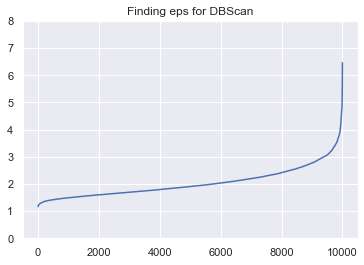

In [243]:
neigh = NearestNeighbors(n_neighbors=32)
neigh.fit(data_scaled)
distances, _ = neigh.kneighbors(data_scaled)
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.ylim(0,8)
plt.title('Finding eps for DBScan')
plt.show()

In [244]:
model=DBSCAN(eps = 3, min_samples =36, n_jobs=-1 ).fit(data_scaled)
labels = model.labels_
labels_df =  pd.DataFrame(labels, columns=['cluster'])
labels_df['cluster'].value_counts()

 0    9883
-1     117
Name: cluster, dtype: int64

In [245]:
#concat outlier labels to initial data 
outlier_label = pd.concat([wineDf,pd.DataFrame(labels)], axis=1)
outlier_label.rename(columns={0:'label'}, inplace=True)


In [246]:
#store the outlier rows
outliers = outlier_label[outlier_label['label']==-1]
outliers.drop('label', axis =1, inplace = True)

In [247]:
#remove the outliers from original data
wineDf = outlier_label[outlier_label['label']==0]
wineDf.drop('label', axis = 1, inplace = True)

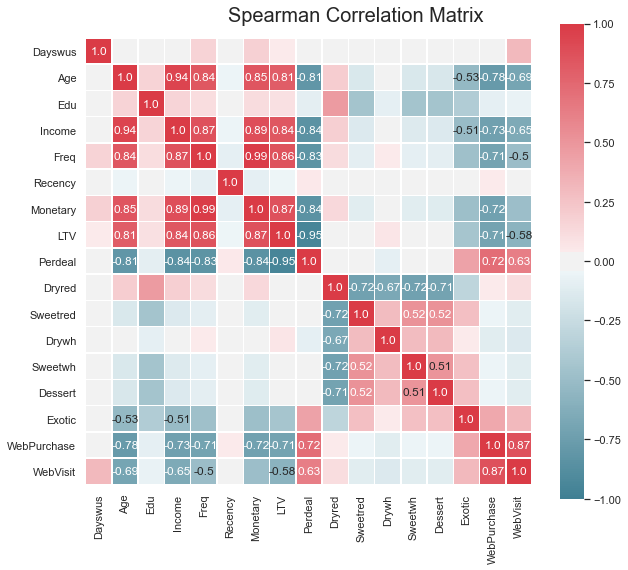

In [248]:
# Prepare figure
fig = plt.figure(figsize=(10, 8))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(wineDf[features].corr(method="spearman"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,""))

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Spearman Correlation Matrix", fontsize=20)

plt.show()

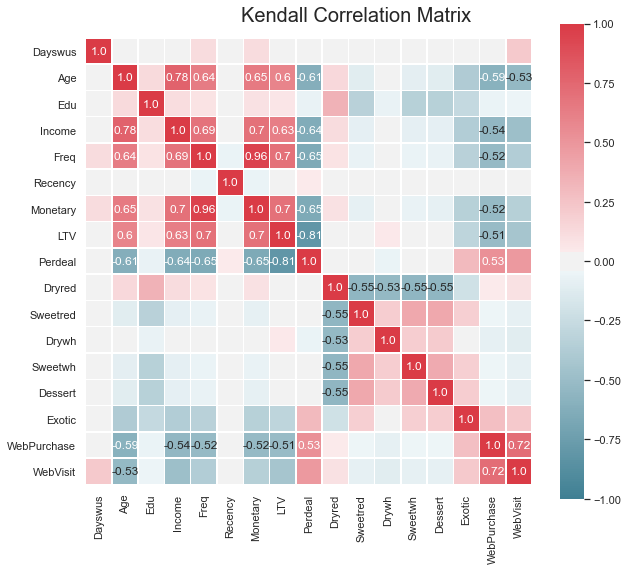

In [249]:
# Prepare figure
fig = plt.figure(figsize=(10, 8))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(wineDf[features].corr(method="kendall"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,""))

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Kendall Correlation Matrix", fontsize=20)

plt.show()

In [250]:
DF_ = wineDf.copy()

In [251]:
wineDf.drop(['Income','WebVisit','LTV', 'Recency'],inplace = True, axis =1 )

features.remove('Income')
features.remove('WebVisit')
features.remove('Recency')
features.remove('LTV')


## RFM

In [252]:
# Use MinMaxScaler to scale the data
df_minmax = DF_.copy()
features_RFM = df_minmax.columns.to_list()
df_minmax = scale_minMax(df_minmax,features_RFM)

In [253]:
df_RFM = df_minmax.copy()
RFM_table = df_RFM[['Custid','Recency','Freq','Monetary']]
RFM_table.set_index('Custid', inplace = True)
df_RFM.set_index('Custid', inplace = True)

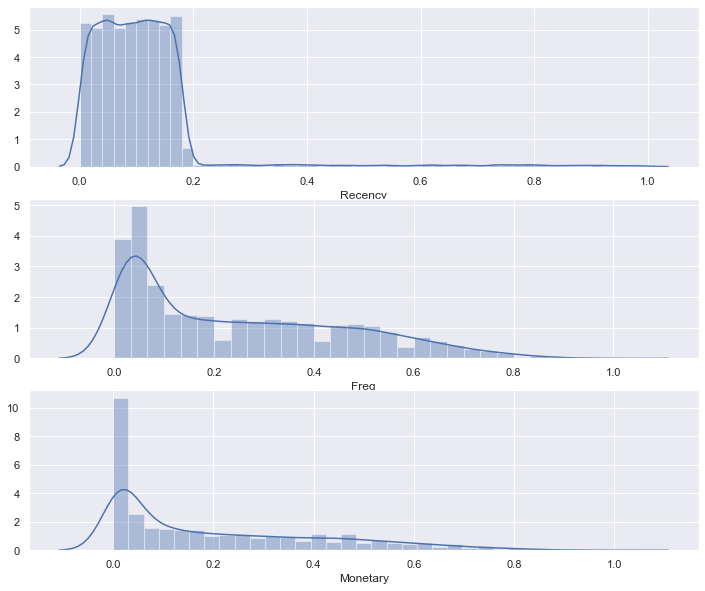

In [254]:
# Plotting RFM distributions
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(RFM_table['Recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(RFM_table['Freq'])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(RFM_table['Monetary'])
# Show the plot
plt.show()

In [255]:
#Calculating R and F groups
# Create labels for Recency and Frequency
r_labels = range(5, 0, -1); f_labels = range(1, 6)
# Assign these labels to 4 equal percentile groups 
r_groups = pd.qcut(RFM_table['Recency'], q=5, labels=r_labels)
# Assign these labels to 4 equal percentile groups 
f_groups = pd.qcut(RFM_table['Freq'], q=5, labels=f_labels)
# Create new columns R and F 
RFM_table = RFM_table.assign(R = r_groups.values, F = f_groups.values)
# Create labels for MonetaryValue
m_labels = range(1, 6)
# Assign these labels to three equal percentile groups 
m_groups = pd.qcut(RFM_table['Monetary'], q=5, labels=m_labels)
# Create new column M
RFM_table = RFM_table.assign(M = m_groups.values)
RFM_table

Recency      Freq  Monetary  R  F  M
Custid                                         
0.432443  0.032787  0.345455  0.269206  5  4  4
0.295530  0.060109  0.636364  0.606041  4  5  5
0.268027  0.102004  0.054545  0.010834  3  2  1
0.182818  0.083789  0.018182  0.010177  3  1  1
0.778778  0.005464  0.018182  0.009849  5  1  1
...            ...       ...       ... .. .. ..
0.038204  0.107468  0.327273  0.252791  3  4  4
0.306931  0.081967  0.309091  0.234406  3  4  4
0.690869  0.118397  0.036364  0.013460  2  1  1
0.315732  0.670310  0.000000  0.002955  1  1  1
0.391339  0.051002  0.436364  0.374918  4  4  4

[9883 rows x 6 columns]

In [256]:
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])
RFM_table['RFM_Segment_Concat'] = RFM_table.apply(join_rfm, axis=1)
rfm = RFM_table
rfm.head()

Recency      Freq  Monetary  R  F  M RFM_Segment_Concat
Custid                                                            
0.432443  0.032787  0.345455  0.269206  5  4  4                544
0.295530  0.060109  0.636364  0.606041  4  5  5                455
0.268027  0.102004  0.054545  0.010834  3  2  1                321
0.182818  0.083789  0.018182  0.010177  3  1  1                311
0.778778  0.005464  0.018182  0.009849  5  1  1                511

In [257]:
rfm_count_unique = rfm.groupby('RFM_Segment_Concat')['RFM_Segment_Concat'].nunique()
print(rfm_count_unique.sum())
# Calculate RFM_Score
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)
print(rfm['RFM_Score'])

41
Custid
0.432443    13.0
0.295530    14.0
0.268027     6.0
0.182818     5.0
0.778778     7.0
            ... 
0.038204    11.0
0.306931    11.0
0.690869     4.0
0.315732     3.0
0.391339    12.0
Name: RFM_Score, Length: 9883, dtype: float64


In [258]:
# Define rfm_level function
def rfm_level(df):
    if df['RFM_Score'] >= 13:
        return 'Can\'t Loose Them'
    elif ((df['RFM_Score'] >= 12) and (df['RFM_Score'] < 13)):
        return 'Champions'
    elif ((df['RFM_Score'] >=11) and (df['RFM_Score'] < 12)):
        return 'Loyal/Commited'
    elif ((df['RFM_Score'] >= 10) and (df['RFM_Score'] < 11)):
        return 'Potential'
    elif ((df['RFM_Score'] >= 9) and (df['RFM_Score'] < 10)):
        return 'Promising'
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 9)):
        return 'Requires Attention'
    else:
        return 'Demands Activation'

# Create a new variable RFM_Level
rfm['RFM_Level'] = rfm.apply(rfm_level, axis=1)
# Printing the header with top 15 rows 
rfm

Recency      Freq  Monetary  R  F  M RFM_Segment_Concat  RFM_Score  \
Custid                                                                          
0.432443  0.032787  0.345455  0.269206  5  4  4                544       13.0   
0.295530  0.060109  0.636364  0.606041  4  5  5                455       14.0   
0.268027  0.102004  0.054545  0.010834  3  2  1                321        6.0   
0.182818  0.083789  0.018182  0.010177  3  1  1                311        5.0   
0.778778  0.005464  0.018182  0.009849  5  1  1                511        7.0   
...            ...       ...       ... .. .. ..                ...        ...   
0.038204  0.107468  0.327273  0.252791  3  4  4                344       11.0   
0.306931  0.081967  0.309091  0.234406  3  4  4                344       11.0   
0.690869  0.118397  0.036364  0.013460  2  1  1                211        4.0   
0.315732  0.670310  0.000000  0.002955  1  1  1                111        3.0   
0.391339  0.051002  0.436364  0.374918  4  4  4                444       12.0   

                   RFM_Level  
Custid                        
0.432443    Can't Loose Them  
0.295530    Can't Loose Them  
0.268027  Demands Activation  
0.182818  Demands Activation  
0.778778  Demands Activation  
...                      ...  
0.038204      Loyal/Commited  
0.306931      Loyal/Commited  
0.690869  Demands Activation  
0.315732  Demands Activation  
0.391339           Champions  

[9883 rows x 9 columns]

In [259]:
RFM_final = pd.concat([df_RFM, rfm['RFM_Level']], axis = 1)

In [260]:
#RFM_final = pd.concat([df_RFM, rfm.drop(['Recency', 'Freq', 'Monetary'], axis = 1)], axis = 1)

rfm_level_agg = RFM_final.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Freq': 'mean',
    'Monetary': 'mean',
    'Dayswus' : 'mean',
    'Age' : 'mean',
    'Edu': 'mean',
    'Perdeal' : 'mean',
    'Dryred' : 'mean',
    'Sweetred': 'mean',
    'Drywh': 'mean',
    'Sweetwh': 'mean',
    'Dessert' : 'mean',
    'Exotic' : 'mean',
    'WebPurchase': ['mean', 'count'],
   
    
}).round(1)
# Print the aggregated dataset
rfm_level_agg


Recency Freq Monetary Dayswus  Age  Edu Perdeal Dryred  \
                      mean mean     mean    mean mean mean    mean   mean   
RFM_Level                                                                   
Can't Loose Them       0.0  0.5      0.5     0.6  0.8  0.6     0.1    0.5   
Champions              0.1  0.5      0.4     0.5  0.8  0.6     0.1    0.5   
Demands Activation     0.2  0.1      0.0     0.4  0.3  0.6     0.6    0.4   
Loyal/Commited         0.1  0.4      0.3     0.5  0.7  0.6     0.2    0.6   
Potential              0.1  0.3      0.2     0.5  0.6  0.6     0.2    0.6   
Promising              0.1  0.2      0.2     0.5  0.5  0.6     0.3    0.6   
Requires Attention     0.1  0.1      0.1     0.5  0.4  0.6     0.4    0.5   

                   Sweetred Drywh Sweetwh Dessert Exotic WebPurchase        
                       mean  mean    mean    mean   mean        mean count  
RFM_Level                                                                   
Can't Loose Them        0.1   0.4     0.1     0.1    0.1         0.2  1584  
Champions               0.1   0.4     0.1     0.1    0.1         0.3   831  
Demands Activation      0.2   0.4     0.1     0.2    0.3         0.6  3476  
Loyal/Commited          0.1   0.4     0.1     0.1    0.1         0.4  1192  
Potential               0.1   0.3     0.1     0.1    0.1         0.4   862  
Promising               0.1   0.3     0.1     0.1    0.2         0.5  1044  
Requires Attention      0.1   0.4     0.1     0.1    0.2         0.6   894

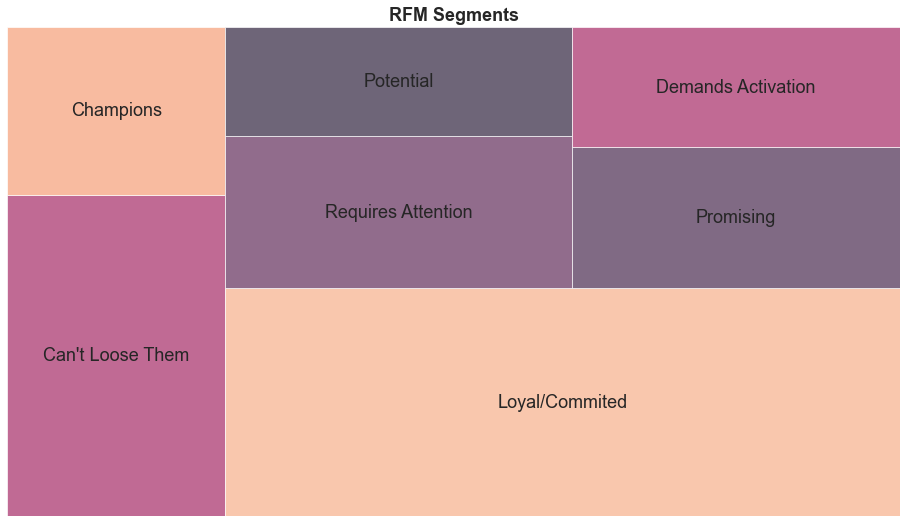

In [261]:
rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean','DayswusMean','AgeMean','EduMean','PerdealMean','DryredMean','SweetredMean','DrywhMean', 'SweetwhMean', 'DessertMean', 'ExoticMean', 'WebPurchaseMean', 'Count']
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['Can\'t Loose Them',
                     'Champions',
                     'Loyal/Commited',
                     'Requires Attention',
                     'Potential', 
                     'Promising', 
                     'Demands Activation'], alpha=0.65, text_kwargs={'fontsize':18})
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()





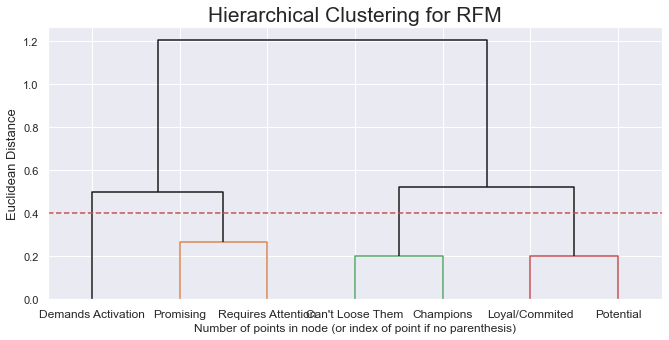

In [262]:
 # Using Hierarchical clustering to merge the concatenated cluster centroids
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)
hclust_labels = hclust.fit_predict(rfm_level_agg.drop('Count', axis =1))
 # create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 0.4
dendrogram(linkage_matrix, truncate_mode='level', labels=rfm_level_agg.index, p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 9000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering for RFM', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

In [263]:
#RFM_final['RFM_Level']=RFM_final.RFM_Level.apply(lambda x: 'Premium' if (x == 'Can\'t Loose Them') else ('Loyal' if ((x == 'Champions') | (x == 'Loyal/Commited')) else ('Promising' if ((x == 'Potential') | (x == 'Promising'))  else 'Unprofitable')))
RFM_final['RFM_Level']=RFM_final.RFM_Level.apply(lambda x: 'Champions' if ((x == 'Can\'t Loose Them') | (x == 'Champions')) else ('Loyal' if ((x == 'Potential') | (x == 'Loyal/Commited')) else ('Promising' if ((x == 'Requires Attention') | (x == 'Promising'))  else 'Unprofitable')))

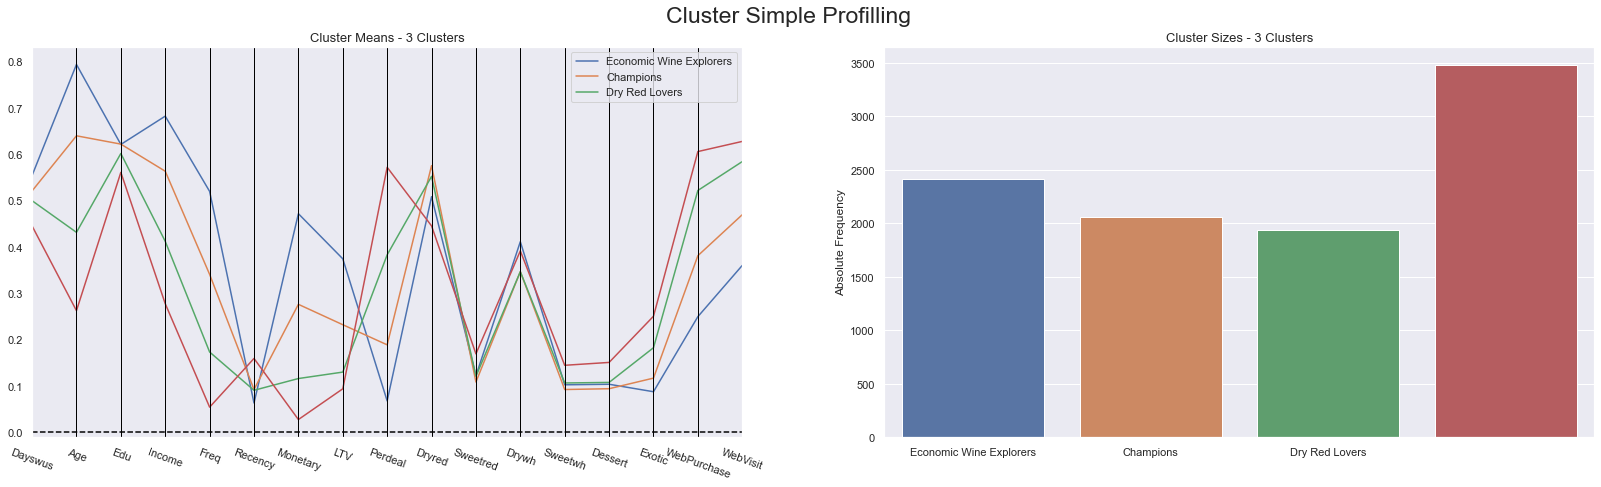

In [264]:
cluster_profiles(RFM_final,['RFM_Level'],figsize = (28, 7))

In [265]:
RFM_final.groupby("RFM_Level").mean().round(2)


Dayswus   Age   Edu  Income  Freq  Recency  Monetary   LTV  \
RFM_Level                                                                  
Champions        0.55  0.79  0.62    0.68  0.52     0.06      0.47  0.37   
Loyal            0.52  0.64  0.62    0.56  0.34     0.09      0.28  0.23   
Promising        0.50  0.43  0.60    0.41  0.17     0.09      0.12  0.13   
Unprofitable     0.44  0.26  0.56    0.28  0.05     0.16      0.03  0.09   

              Perdeal  Dryred  Sweetred  Drywh  Sweetwh  Dessert  Exotic  \
RFM_Level                                                                  
Champions        0.07    0.51      0.12   0.41     0.10     0.10    0.09   
Loyal            0.19    0.57      0.11   0.35     0.09     0.09    0.12   
Promising        0.38    0.55      0.12   0.35     0.11     0.11    0.18   
Unprofitable     0.57    0.44      0.17   0.39     0.14     0.15    0.25   

              WebPurchase  WebVisit  
RFM_Level                            
Champions            0.25      0.36  
Loyal                0.38      0.47  
Promising            0.52      0.58  
Unprofitable         0.61      0.63


## Segmentation

In [266]:
behavior_features=[
    'Dayswus',
    'Age',
    'Freq',
    'Edu',
    'Monetary',
    'WebPurchase']
winetype_features=[
    'Dryred', 
    'Sweetred', 
    'Drywh', 
    'Sweetwh', 
    'Dessert',
    'Exotic']
behaviorDf=wineDf[behavior_features]
winetypeDf=wineDf[winetype_features]

In [267]:
behaviorDf_scaled = scale_minMax(behaviorDf,behavior_features)
winetypeDf_scaled = scale_minMax(winetypeDf,winetype_features)

## Clustering

### K-Means and Hierarchical


#### Behavior View 

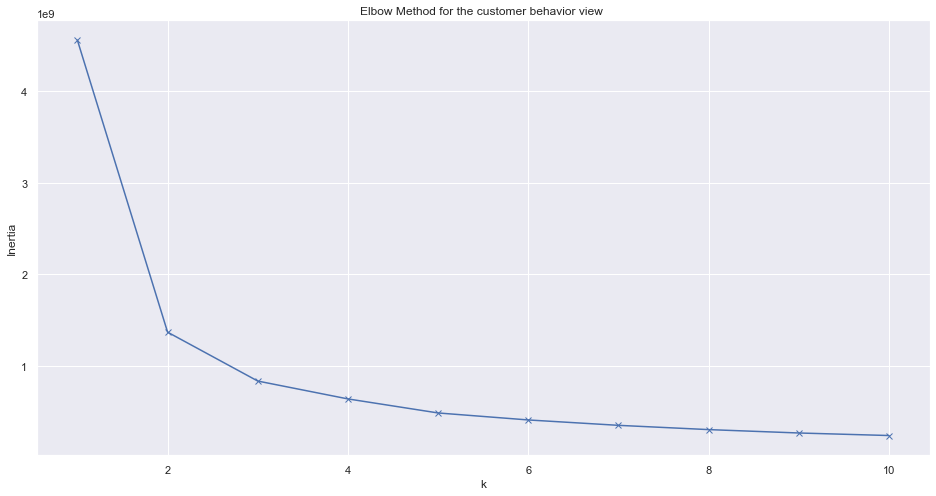

In [268]:
kmeans_elbow(behaviorDf, 'behavior ') 

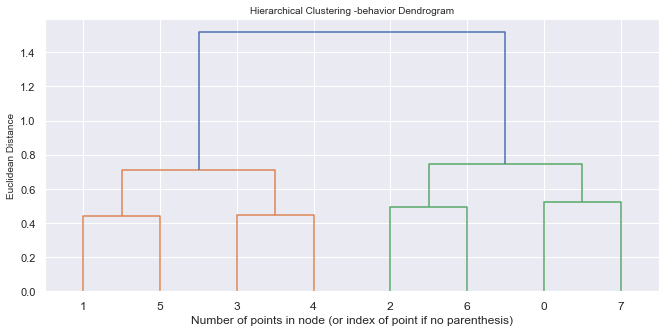

In [269]:
kmeans_hierarchical(behaviorDf_scaled, 'behavior ') 

In [270]:
apply_kmeans(behaviorDf,wineDf,behaviorDf_scaled,4,'behavior')

In [271]:
behaviorDf.groupby("kmeans_labels").mean().round(2)
#r2(behaviorDf,behaviorDf.drop(['kmeans_labels'], axis = 1).columns.to_list(), 'kmeans_labels')

Dayswus    Age   Freq    Edu  Monetary  WebPurchase
kmeans_labels                                                     
0               728.51  35.85   4.99  16.59    123.87        54.64
1               734.61  64.53  22.27  17.01    994.28        26.02
2              1071.71  66.33  31.07  17.01   1536.78        23.75
3              1078.35  36.70   8.41  16.60    274.08        53.83

#### Wine Type View

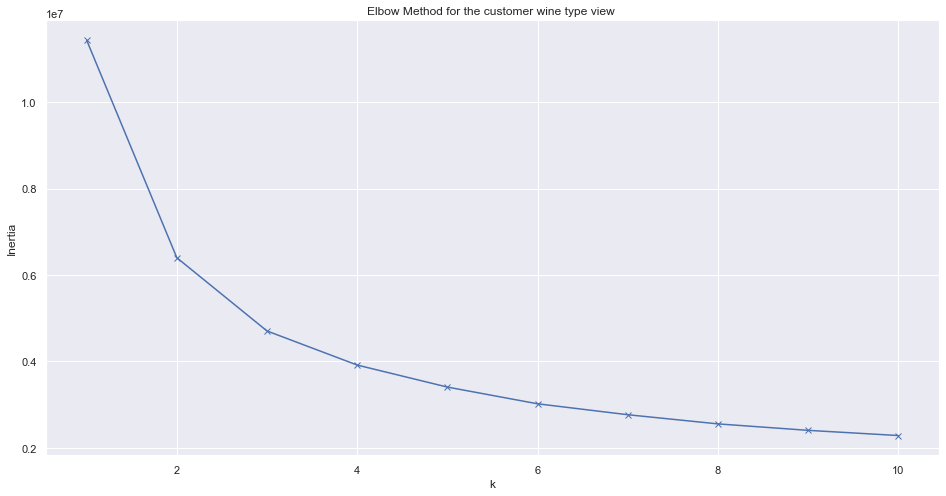

In [57]:
kmeans_elbow(winetypeDf,'wine type ')

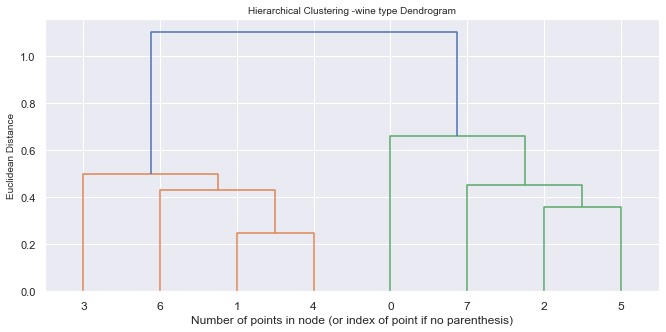

In [58]:
kmeans_hierarchical(winetypeDf_scaled, 'wine type ') 

In [272]:
apply_kmeans(winetypeDf,wineDf,winetypeDf_scaled,3,'wine_type')


In [273]:
winetypeDf.groupby("kmeans_labels").mean().round(2)
#r2(winetypeDf,winetypeDf.drop(['kmeans_labels'], axis = 1).columns.to_list(), 'kmeans_labels')

Dryred  Sweetred  Drywh  Sweetwh  Dessert  Exotic
kmeans_labels                                                   
0               40.69      6.91  38.29     7.06     7.05   12.29
1               73.69      2.55  18.62     2.60     2.49   11.72
2               19.82     17.67  28.49    17.39    16.62   37.58

## SOM and Hierarchical

#### Behavior View

In [75]:
### finding hierarchical method for behavior 


#find_hc_method(behaviorDf_scaled,behavior_features)

In [62]:
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
linkage_behavior = 'ward'
distance = 'euclidean'
hclust_behavior = AgglomerativeClustering(linkage=linkage_behavior, affinity=distance, distance_threshold=0, n_clusters=None)
hclust_behavior.fit_predict(behaviorDf_scaled[behavior_features])

array([5235, 6886, 9455, ...,    1,    2,    0], dtype=int64)

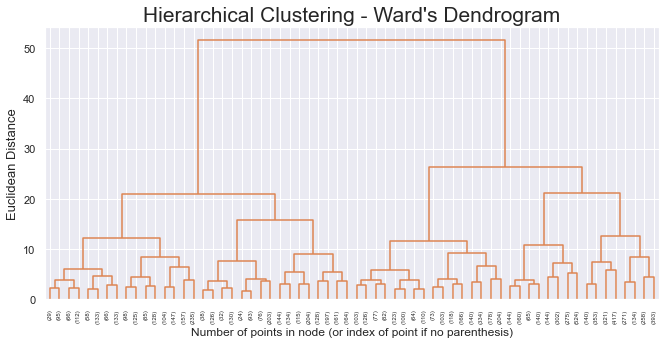

In [63]:
do_dendogram(hclust_behavior,linkage_behavior)

In [274]:
np.random.seed(42)

# Notice that the SOM did not converge - We're under a time constraint for this class
sm_behavior = sompy.SOMFactory().build(
    behaviorDf_scaled.values, 
    mapsize=[50, 50], 
    initialization='random',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=features
)
sm_behavior.train(n_job=-1, verbose='info', train_rough_len=100, train_finetune_len=100)



 Training...
 random_initialization took: 0.002000 seconds
 Rough training...
 radius_ini: 17.000000 , radius_final: 2.833333, trainlen: 100

 epoch: 1 ---> elapsed time:  0.749000, quantization error: 0.856966

 epoch: 2 ---> elapsed time:  0.823000, quantization error: 2.323606

 epoch: 3 ---> elapsed time:  0.716000, quantization error: 2.277981

 epoch: 4 ---> elapsed time:  0.765000, quantization error: 2.265848

 epoch: 5 ---> elapsed time:  0.690000, quantization error: 2.262920

 epoch: 6 ---> elapsed time:  0.720000, quantization error: 2.260999

 epoch: 7 ---> elapsed time:  0.871000, quantization error: 2.259423

 epoch: 8 ---> elapsed time:  0.827000, quantization error: 2.257754

 epoch: 9 ---> elapsed time:  0.766000, quantization error: 2.256235

 epoch: 10 ---> elapsed time:  0.811000, quantization error: 2.254913

 epoch: 11 ---> elapsed time:  0.737000, quantization error: 2.253579

 epoch: 12 ---> elapsed time:  0.723000, quantization error: 2.252200

 epoch: 13 --->

 epoch: 14 ---> elapsed time:  0.913000, quantization error: 1.388218

 epoch: 15 ---> elapsed time:  0.962000, quantization error: 1.379763

 epoch: 16 ---> elapsed time:  0.885000, quantization error: 1.371222

 epoch: 17 ---> elapsed time:  0.976000, quantization error: 1.362675

 epoch: 18 ---> elapsed time:  0.723000, quantization error: 1.354145

 epoch: 19 ---> elapsed time:  0.747000, quantization error: 1.345925

 epoch: 20 ---> elapsed time:  0.791000, quantization error: 1.337628

 epoch: 21 ---> elapsed time:  0.789000, quantization error: 1.329392

 epoch: 22 ---> elapsed time:  0.790000, quantization error: 1.321183

 epoch: 23 ---> elapsed time:  0.721000, quantization error: 1.312851

 epoch: 24 ---> elapsed time:  0.736000, quantization error: 1.304505

 epoch: 25 ---> elapsed time:  0.707000, quantization error: 1.296095

 epoch: 26 ---> elapsed time:  0.756000, quantization error: 1.287781

 epoch: 27 ---> elapsed time:  0.757000, quantization error: 1.279417

 epoch

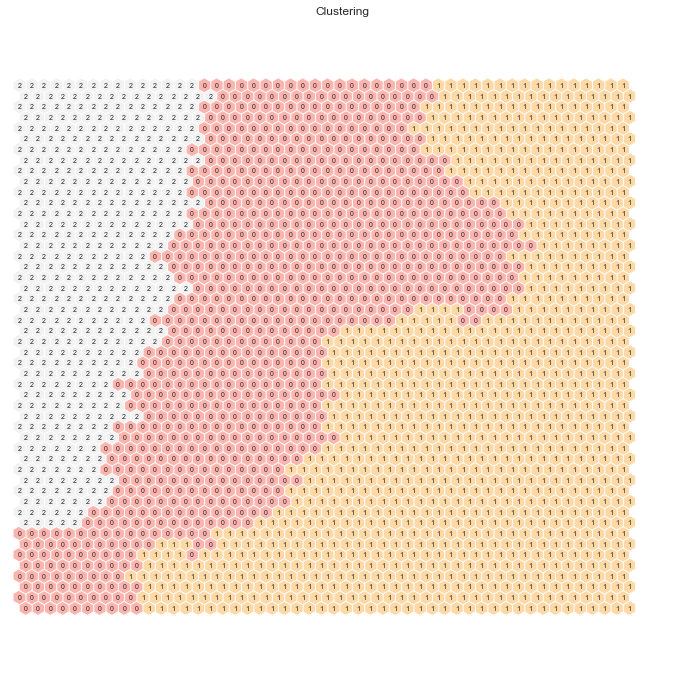

In [275]:
hclust_behavior_som = AgglomerativeClustering(n_clusters=3, linkage='ward')
behaviorDf.loc[:,'SOM_labels'] = hclust_behavior_som.fit_predict(sm_behavior._data)
wineDf.loc[:,'b_SOM_labels'] = hclust_behavior_som.fit_predict(sm_behavior._data)

nodeclus_labels_behavior_som = hclust_behavior_som.fit_predict(sm_behavior.codebook.matrix)
sm_behavior.cluster_labels = nodeclus_labels_behavior_som  # setting the cluster labels of sompy

hits  = HitMapView(12, 12,"Clustering",text_size=10)
hits.show(sm_behavior, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

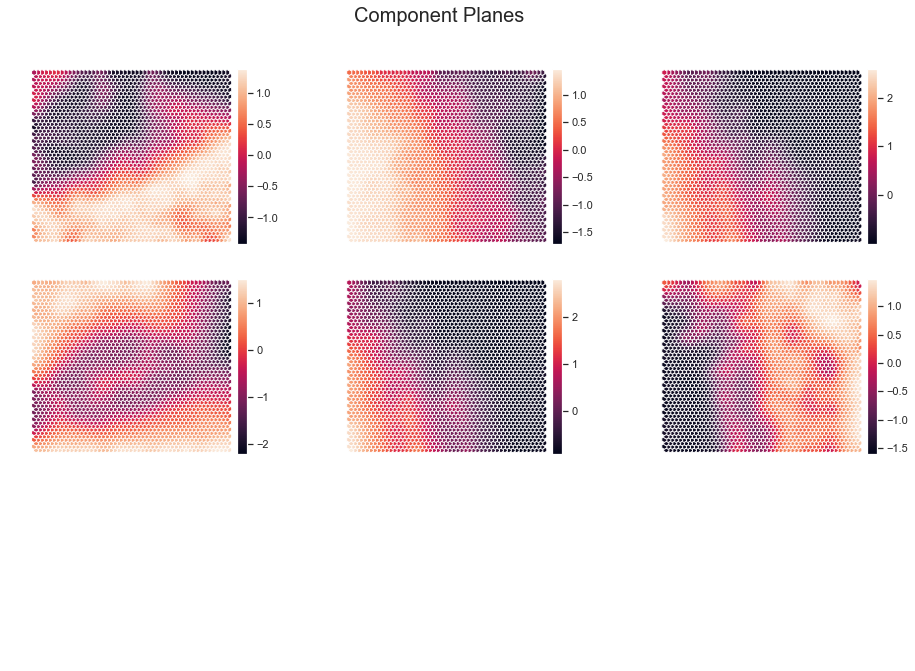

In [276]:
# Component planes on the 50x50 grid
sns.set()
view2D = View2D(12,12,"", text_size=10)
view2D.show(sm_behavior, col_sz=3, what='codebook')
plt.subplots_adjust(top=0.90)
plt.suptitle("Component Planes", fontsize=20)
plt.show()
np.random.seed(42)

In [277]:
behaviorDf.drop('kmeans_labels', axis = 1).groupby("SOM_labels").mean().round(2)
#r2(behaviorDf.drop('kmeans_labels', axis = 1),behaviorDf.drop(['kmeans_labels', 'SOM_labels'], axis = 1).columns.to_list(), 'SOM_labels')

Dayswus    Age   Freq    Edu  Monetary  WebPurchase
SOM_labels                                                     
0            903.05  46.85  11.91  17.37    443.90        46.81
1            908.54  68.97  30.72  16.95   1514.76        19.13
2            879.93  30.09   4.27  15.46     94.54        56.68

#### Wine Type View

In [76]:
### finding hierarchical method for wine type  


#find_hc_method(winetypeDf_scaled,winetype_features)

In [69]:
linkage_winetype = 'ward'
distance = 'euclidean'
hclust_wine = AgglomerativeClustering(linkage=linkage_winetype, affinity=distance, distance_threshold=0, n_clusters=None)
hclust_wine.fit_predict(winetypeDf_scaled[winetype_features])

array([9881, 8526, 7283, ...,    3,    1,    0], dtype=int64)

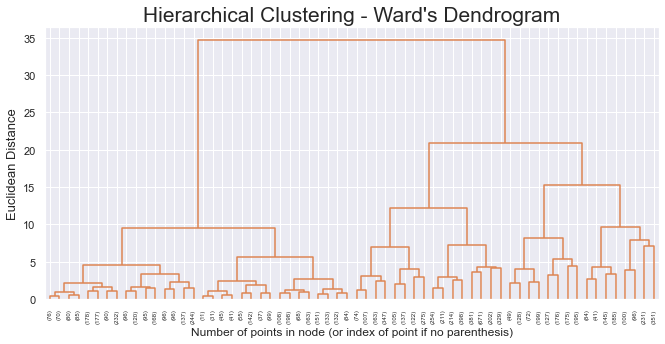

In [70]:
do_dendogram(hclust_wine,linkage_winetype)

In [278]:
np.random.seed(42)

# Notice that the SOM did not converge - We're under a time constraint for this class
sm_winetype = sompy.SOMFactory().build(
    winetypeDf_scaled.values, 
    mapsize=[50, 50], 
    initialization='random',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=features
)
sm_winetype.train(n_job=-1, verbose='info', train_rough_len=100, train_finetune_len=100)



 Training...
 random_initialization took: 0.001000 seconds
 Rough training...
 radius_ini: 17.000000 , radius_final: 2.833333, trainlen: 100

 epoch: 1 ---> elapsed time:  0.817000, quantization error: 1.490222

 epoch: 2 ---> elapsed time:  0.865000, quantization error: 2.172283

 epoch: 3 ---> elapsed time:  1.076000, quantization error: 2.132932

 epoch: 4 ---> elapsed time:  1.193000, quantization error: 2.126192

 epoch: 5 ---> elapsed time:  1.180000, quantization error: 2.119290

 epoch: 6 ---> elapsed time:  1.309000, quantization error: 2.115863

 epoch: 7 ---> elapsed time:  1.331000, quantization error: 2.110585

 epoch: 8 ---> elapsed time:  1.234000, quantization error: 2.101629

 epoch: 9 ---> elapsed time:  1.112000, quantization error: 2.099527

 epoch: 10 ---> elapsed time:  1.264000, quantization error: 2.097834

 epoch: 11 ---> elapsed time:  1.812000, quantization error: 2.096165

 epoch: 12 ---> elapsed time:  1.363000, quantization error: 2.094480

 epoch: 13 --->

 epoch: 14 ---> elapsed time:  0.858000, quantization error: 1.336969

 epoch: 15 ---> elapsed time:  1.168000, quantization error: 1.330383

 epoch: 16 ---> elapsed time:  0.850000, quantization error: 1.323679

 epoch: 17 ---> elapsed time:  0.865000, quantization error: 1.316990

 epoch: 18 ---> elapsed time:  0.966000, quantization error: 1.310212

 epoch: 19 ---> elapsed time:  0.950000, quantization error: 1.303574

 epoch: 20 ---> elapsed time:  0.873000, quantization error: 1.296926

 epoch: 21 ---> elapsed time:  0.812000, quantization error: 1.290294

 epoch: 22 ---> elapsed time:  0.977000, quantization error: 1.283677

 epoch: 23 ---> elapsed time:  0.753000, quantization error: 1.276865

 epoch: 24 ---> elapsed time:  0.848000, quantization error: 1.270108

 epoch: 25 ---> elapsed time:  0.782000, quantization error: 1.263254

 epoch: 26 ---> elapsed time:  0.915000, quantization error: 1.256403

 epoch: 27 ---> elapsed time:  0.893000, quantization error: 1.249534

 epoch

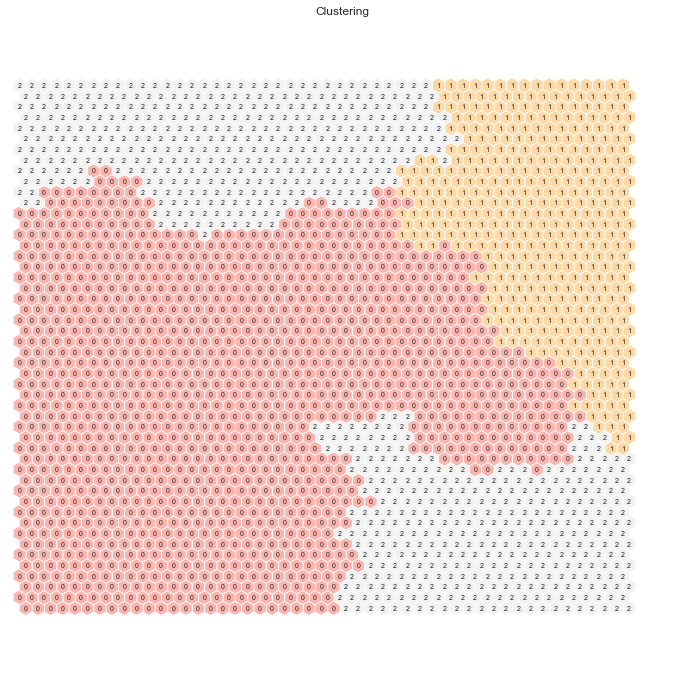

In [279]:
hclust_winetype_som = AgglomerativeClustering(n_clusters=3, linkage='ward')
winetypeDf.loc[:,'SOM_labels'] = hclust_winetype_som.fit_predict(sm_winetype._data)
wineDf.loc[:,'wine_SOM_labels'] = hclust_winetype_som.fit_predict(sm_winetype._data)


nodeclus_labels_winetype_som = hclust_winetype_som.fit_predict(sm_winetype.codebook.matrix)
sm_winetype.cluster_labels = nodeclus_labels_winetype_som  # setting the cluster labels of sompy

hits  = HitMapView(12, 12,"Clustering",text_size=10)
hits.show(sm_winetype, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()


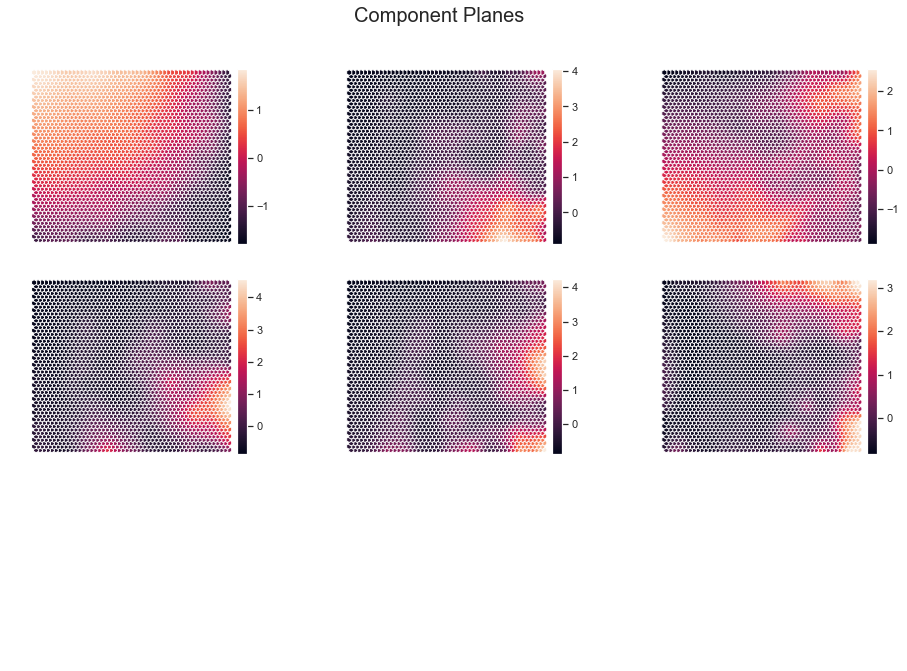

In [73]:
# Component planes on the 50x50 grid
sns.set()
view2D = View2D(12,12,"", text_size=10)
view2D.show(sm_winetype, col_sz=3, what='codebook')
plt.subplots_adjust(top=0.90)
plt.suptitle("Component Planes", fontsize=20)
plt.show()


In [280]:
winetypeDf.drop('kmeans_labels', axis = 1).groupby("SOM_labels").mean().round(2)
#r2(winetypeDf.drop('kmeans_labels', axis = 1),winetypeDf.drop(['kmeans_labels', 'SOM_labels'], axis = 1).columns.to_list(), 'SOM_labels')

Dryred  Sweetred  Drywh  Sweetwh  Dessert  Exotic
SOM_labels                                                   
0            69.40      2.70  22.13     2.86     2.87   12.32
1            34.75      9.66  37.04     9.34     9.20   16.26
2            12.79     20.76  24.17    21.94    20.33   44.64

## Final Clusters

In [281]:
wineDf.drop(['kmeans_labels_wine_type','kmeans_labels_behavior'], axis = 1, inplace = True)
wineDf.rename(columns = {'b_SOM_labels' : 'Behavior','wine_SOM_labels' : 'wine' }, inplace = True)
wineDf_ = wineDf.copy()
wineDf_ = scale_minMax(wineDf_, features)

In [282]:
# Centroids of the concatenated cluster labels
df_centroids = wineDf_.groupby(['Behavior', 'wine'])\
    [features].mean()
df_centroids

Dayswus       Age       Edu      Freq  Monetary   Perdeal  \
Behavior wine                                                               
0        0     0.503627  0.493994  0.711306  0.206266  0.150152  0.356110   
         1     0.505645  0.454070  0.589117  0.181224  0.130147  0.351160   
         2     0.511675  0.401916  0.438218  0.165517  0.116060  0.332859   
1        0     0.530368  0.828933  0.712920  0.550273  0.506600  0.052545   
         1     0.500793  0.862418  0.565196  0.534415  0.488702  0.031959   
         2     0.501737  0.865315  0.368243  0.517445  0.470284  0.022848   
2        0     0.459608  0.338530  0.541037  0.066558  0.035140  0.595347   
         1     0.464893  0.187798  0.446681  0.060773  0.030265  0.568039   
         2     0.501018  0.055092  0.260435  0.047538  0.018504  0.583967   

                 Dryred  Sweetred     Drywh   Sweetwh   Dessert    Exotic  \
Behavior wine                                                               
0        0     0.726862  0.048504  0.261864  0.042800  0.044904  0.131011   
         1     0.385271  0.187130  0.450930  0.149201  0.154975  0.172988   
         2     0.188013  0.372774  0.331916  0.319349  0.301875  0.326988   
1        0     0.637427  0.062401  0.346655  0.057611  0.062503  0.063987   
         1     0.346272  0.171921  0.528293  0.140795  0.145144  0.084579   
         2     0.173469  0.384738  0.334691  0.386937  0.239450  0.174831   
2        0     0.648197  0.059874  0.337762  0.056891  0.058512  0.203111   
         1     0.297962  0.212590  0.498488  0.180767  0.187814  0.267478   
         2     0.106354  0.413820  0.313949  0.371492  0.372939  0.505440   

               WebPurchase  
Behavior wine               
0        0        0.524133  
         1        0.477142  
         2        0.470717  
1        0        0.223642  
         1        0.153221  
         2        0.134492  
2        0        0.616120  
         1        0.628614  
         2        0.637825

In [283]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)
hclust_labels = hclust.fit_predict(df_centroids)

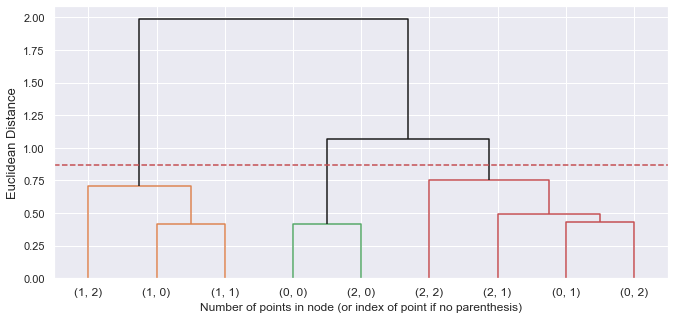

In [285]:
# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 0.87
dendrogram(linkage_matrix, truncate_mode='level', labels=df_centroids.index, p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
#plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

In [286]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    n_clusters=3
)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

df_centroids  # centroid's cluster labels

Dayswus       Age       Edu      Freq  Monetary   Perdeal  \
Behavior wine                                                               
0        0     0.503627  0.493994  0.711306  0.206266  0.150152  0.356110   
         1     0.505645  0.454070  0.589117  0.181224  0.130147  0.351160   
         2     0.511675  0.401916  0.438218  0.165517  0.116060  0.332859   
1        0     0.530368  0.828933  0.712920  0.550273  0.506600  0.052545   
         1     0.500793  0.862418  0.565196  0.534415  0.488702  0.031959   
         2     0.501737  0.865315  0.368243  0.517445  0.470284  0.022848   
2        0     0.459608  0.338530  0.541037  0.066558  0.035140  0.595347   
         1     0.464893  0.187798  0.446681  0.060773  0.030265  0.568039   
         2     0.501018  0.055092  0.260435  0.047538  0.018504  0.583967   

                 Dryred  Sweetred     Drywh   Sweetwh   Dessert    Exotic  \
Behavior wine                                                               
0        0     0.726862  0.048504  0.261864  0.042800  0.044904  0.131011   
         1     0.385271  0.187130  0.450930  0.149201  0.154975  0.172988   
         2     0.188013  0.372774  0.331916  0.319349  0.301875  0.326988   
1        0     0.637427  0.062401  0.346655  0.057611  0.062503  0.063987   
         1     0.346272  0.171921  0.528293  0.140795  0.145144  0.084579   
         2     0.173469  0.384738  0.334691  0.386937  0.239450  0.174831   
2        0     0.648197  0.059874  0.337762  0.056891  0.058512  0.203111   
         1     0.297962  0.212590  0.498488  0.180767  0.187814  0.267478   
         2     0.106354  0.413820  0.313949  0.371492  0.372939  0.505440   

               WebPurchase  hclust_labels  
Behavior wine                              
0        0        0.524133              2  
         1        0.477142              0  
         2        0.470717              0  
1        0        0.223642              1  
         1        0.153221              1  
         2        0.134492              1  
2        0        0.616120              2  
         1        0.628614              0  
         2        0.637825              0

In [287]:
# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids['hclust_labels'].to_dict()

df_ = wineDf_.copy()

# Mapping the hierarchical clusters on the centroids to the observations
df_['merged_labels'] = df_.apply(
    lambda row: cluster_mapper[
        (row['Behavior'], row['wine'])
    ], axis=1
)

# Merged cluster centroids
df_.groupby('merged_labels').mean()[features]

Dayswus       Age       Edu      Freq  Monetary   Perdeal  \
merged_labels                                                               
0              0.489289  0.281858  0.474083  0.111516  0.072181  0.474096   
1              0.512193  0.849568  0.619211  0.540274  0.495325  0.039752   
2              0.495687  0.465952  0.680593  0.181066  0.129407  0.399262   

                 Dryred  Sweetred     Drywh   Sweetwh   Dessert    Exotic  \
merged_labels                                                               
0              0.298779  0.240536  0.442766  0.203804  0.208718  0.270246   
1              0.455860  0.132845  0.455549  0.112343  0.114696  0.077961   
2              0.712673  0.050555  0.275554  0.045342  0.047359  0.144016   

               WebPurchase  
merged_labels               
0                 0.562844  
1                 0.180062  
2                 0.540726

In [288]:
#Merge cluster contigency table
# Getting size of each final cluster
df_counts = df_.groupby('merged_labels')\
    .size()\
    .to_frame()

# Getting the product and behavior labels
df_counts = df_counts\
    .rename({v:k for k, v in cluster_mapper.items()})\
    .reset_index()

df_counts['Behavior'] = df_counts['merged_labels'].apply(lambda x: x[0])
df_counts['wine'] = df_counts['merged_labels'].apply(lambda x: x[1])

In [289]:
wineDf_ = df_.copy()

#### Behavior View

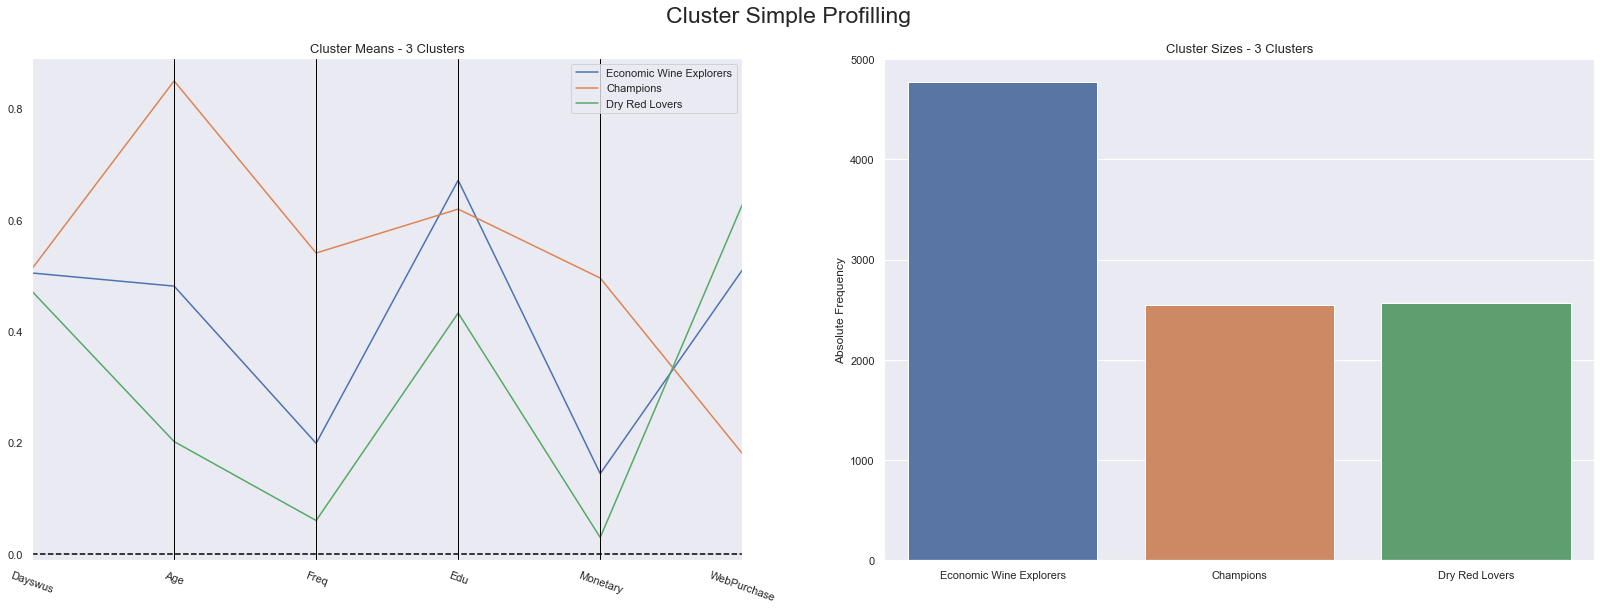

In [290]:
# Profilling each cluster (product, behavior, merged)
cluster_profiles(
    df = wineDf_[behavior_features + ['Behavior']], 
    label_columns = ['Behavior'], 
    figsize = (28, 9), 
)

#### WineType View

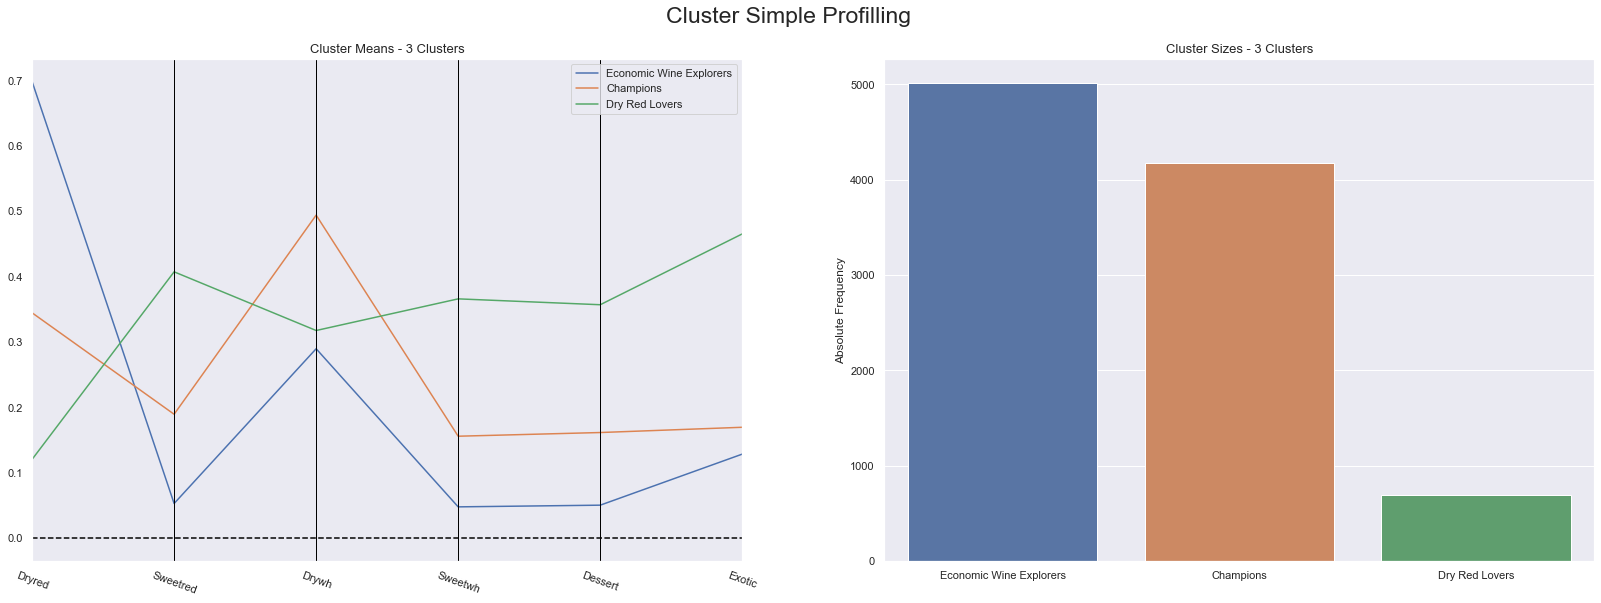

In [291]:
# Profilling each cluster (product, behavior, merged)
cluster_profiles(
    df = wineDf_[winetype_features + ['wine']], 
    label_columns = ['wine'], 
    figsize = (28, 9))

#### Final Solution

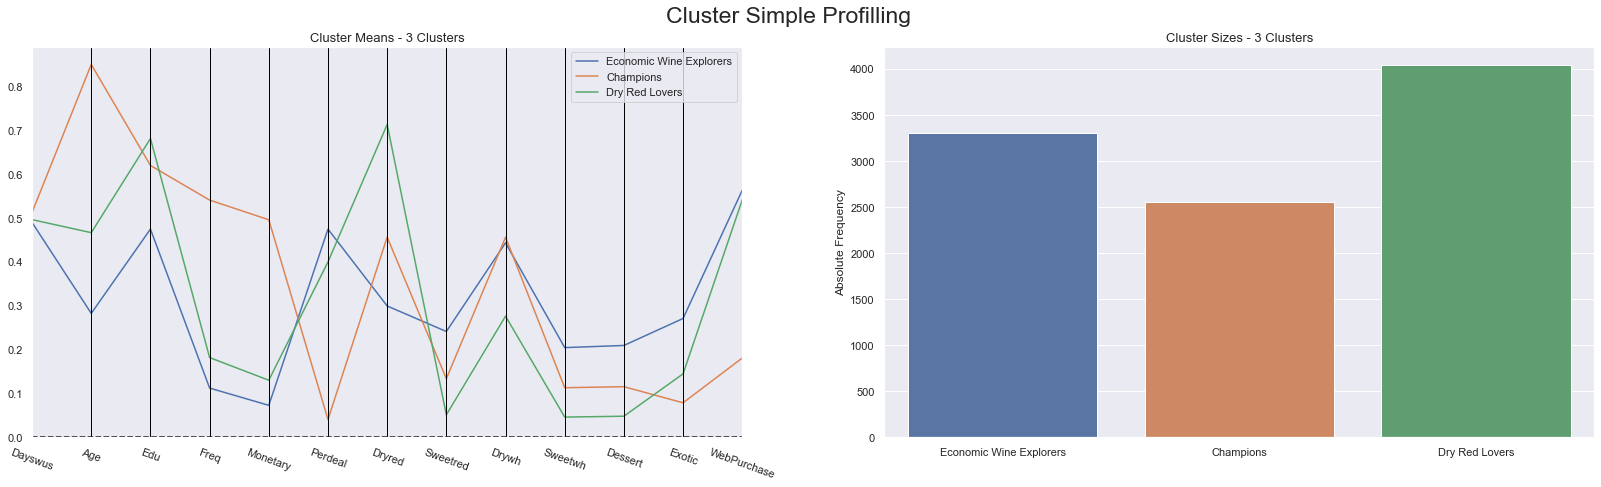

In [292]:
# Profilling each cluster (product, behavior, merged)
cluster_profiles(
    df = wineDf_[features + ['merged_labels']], 
    label_columns = ['merged_labels'], 
    figsize = (28, 7)
)

In [293]:
wineDf = pd.concat([wineDf.drop(['Behavior', 'wine'], axis = 1), wineDf_['merged_labels']], axis = 1)
wineDf.groupby('merged_labels').mean().round(2)

Custid  Dayswus    Age    Edu   Freq  Monetary  Perdeal  \
merged_labels                                                             
0              5963.09   892.50  34.91  15.79   7.13    225.86    45.99   
1              6037.31   908.54  68.97  16.95  30.72   1514.76     3.86   
2              5988.89   896.98  45.96  17.44  10.96    400.17    38.73   

               Dryred  Sweetred  Drywh  Sweetwh  Dessert  Exotic  WebPurchase  
merged_labels                                                                  
0               30.28     12.27  33.32    12.23    11.90   25.94        51.28  
1               45.67      6.78  34.26     6.74     6.54    7.48        19.13  
2               70.84      2.58  21.12     2.72     2.70   13.83        49.42

### Classifying the outliers

In [294]:
# Preparing the data
X = wineDf[features]
y = wineDf.merged_labels

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fitting the decision tree
dt = DecisionTreeClassifier(random_state=42, max_depth=7)
dt.fit(X_train, y_train)
print("It is estimated that in average, we are able to predict {0:.2f}% of the customers correctly".format(dt.score(X_test, y_test)*100))

It is estimated that in average, we are able to predict 91.76% of the customers correctly


In [295]:
scaler = MinMaxScaler()
outliers[features] = scaler.fit_transform(outliers[features])
outliers.loc[:,'merged_labels'] = dt.predict(outliers[features])

outliers.drop(['Income', 'WebVisit', 'Recency', 'LTV'], axis = 1, inplace = True)
outliers.set_index('Custid', inplace = True)
wineDf.set_index('Custid', inplace = True)

#final dataset with classified outliers
Wine = wineDf.append(outliers)

## More Visualizations

### t-SNE

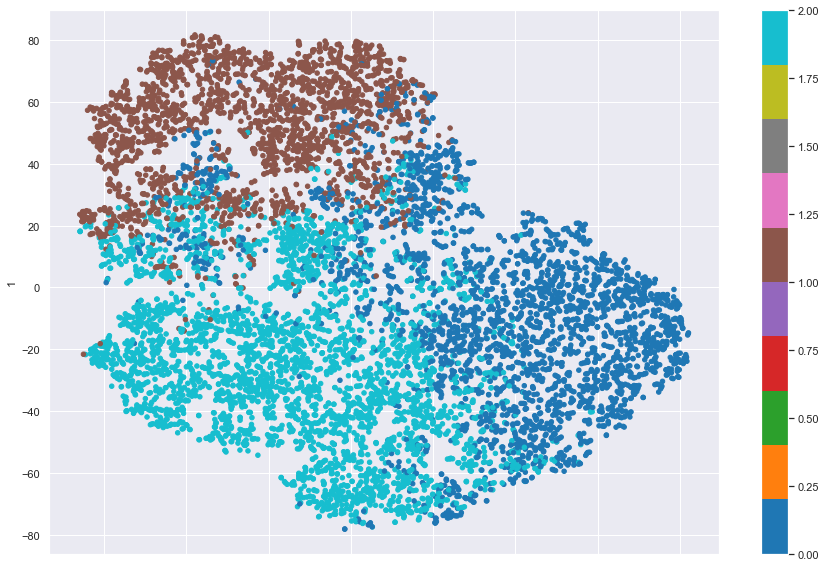

In [179]:
two_dim = TSNE(random_state=42).fit_transform(wineDf_[features])

pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=wineDf_['merged_labels'], colormap='tab10', figsize=(15,10))
plt.show()

### Histograms

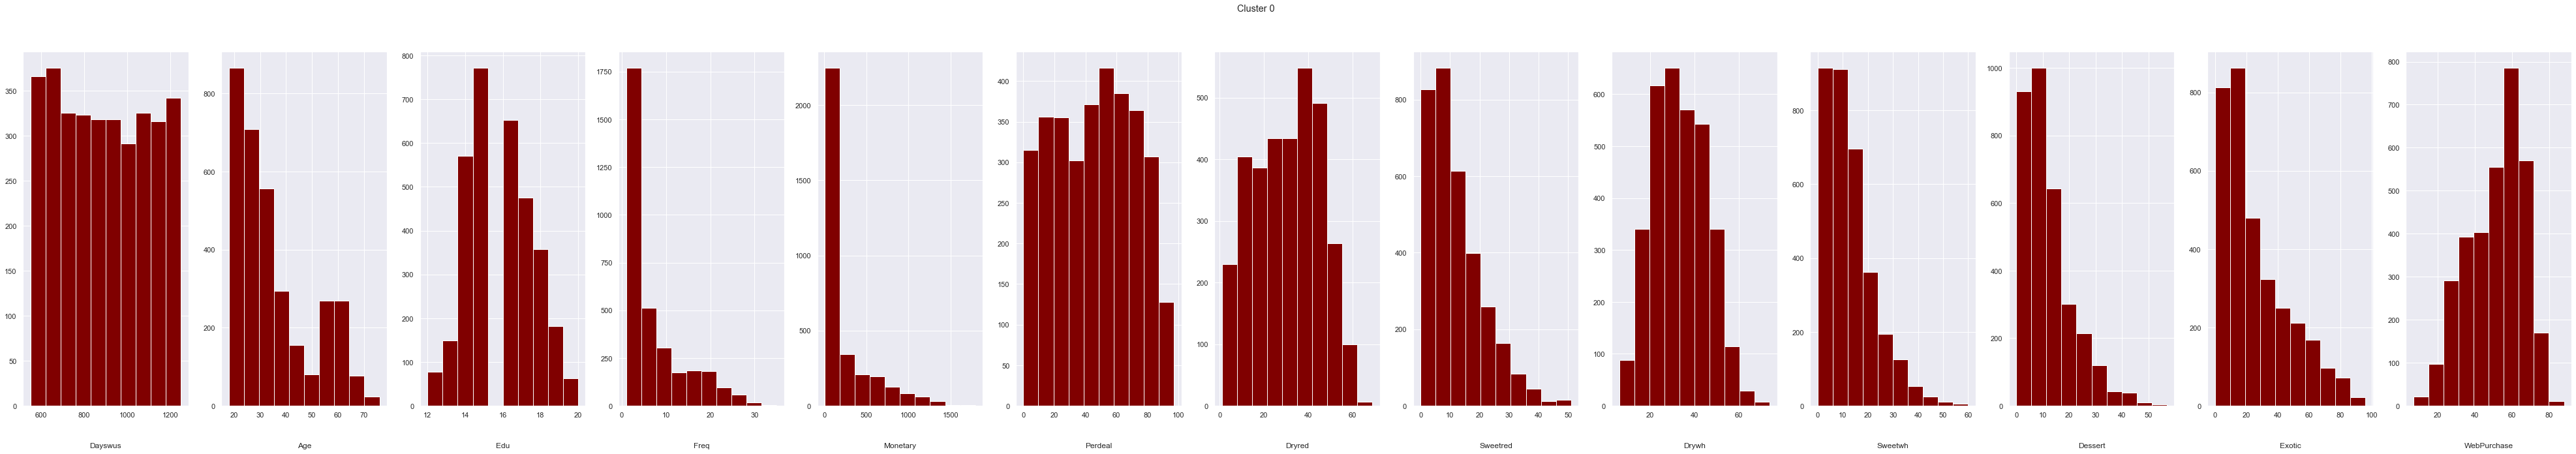

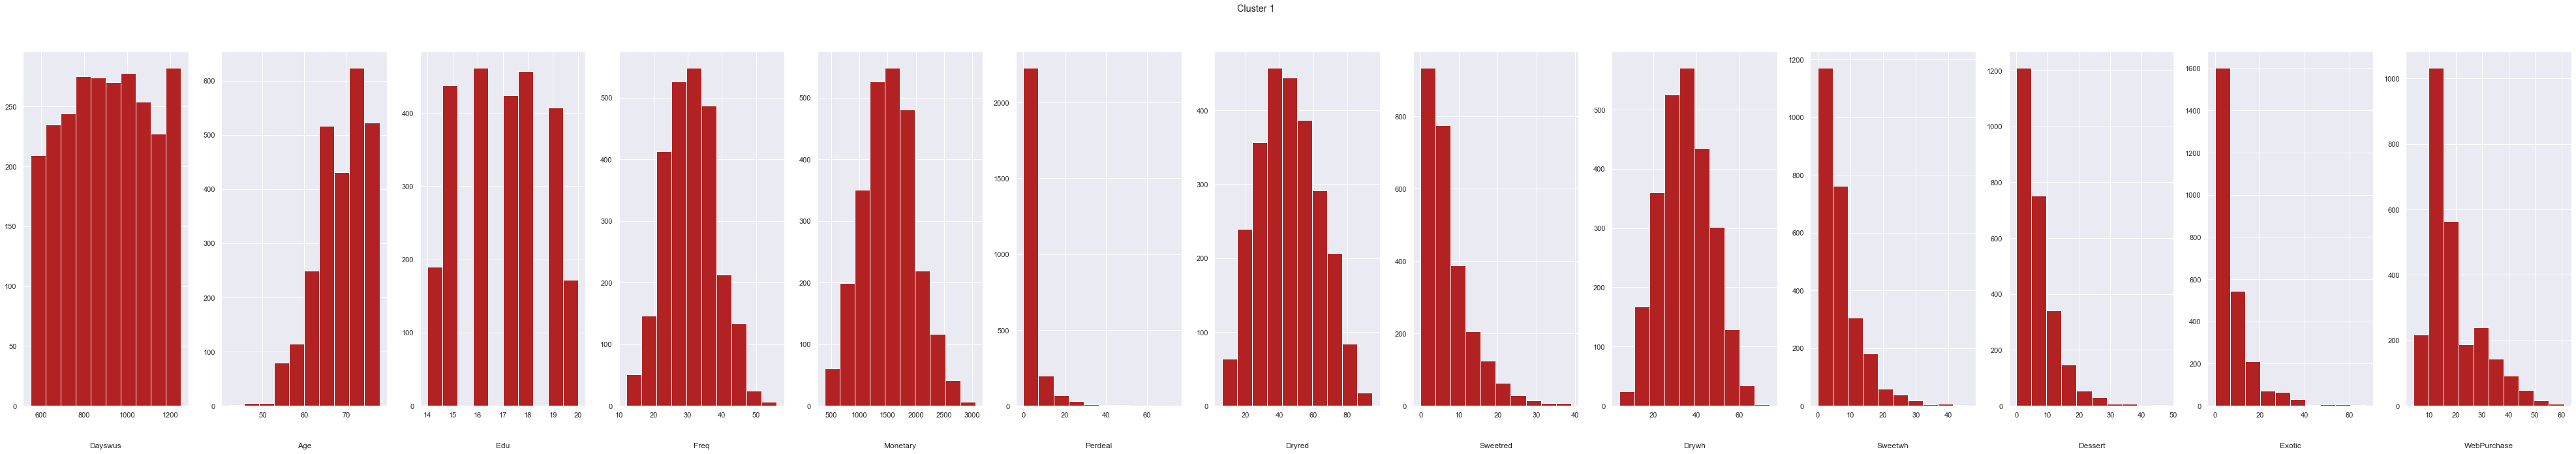

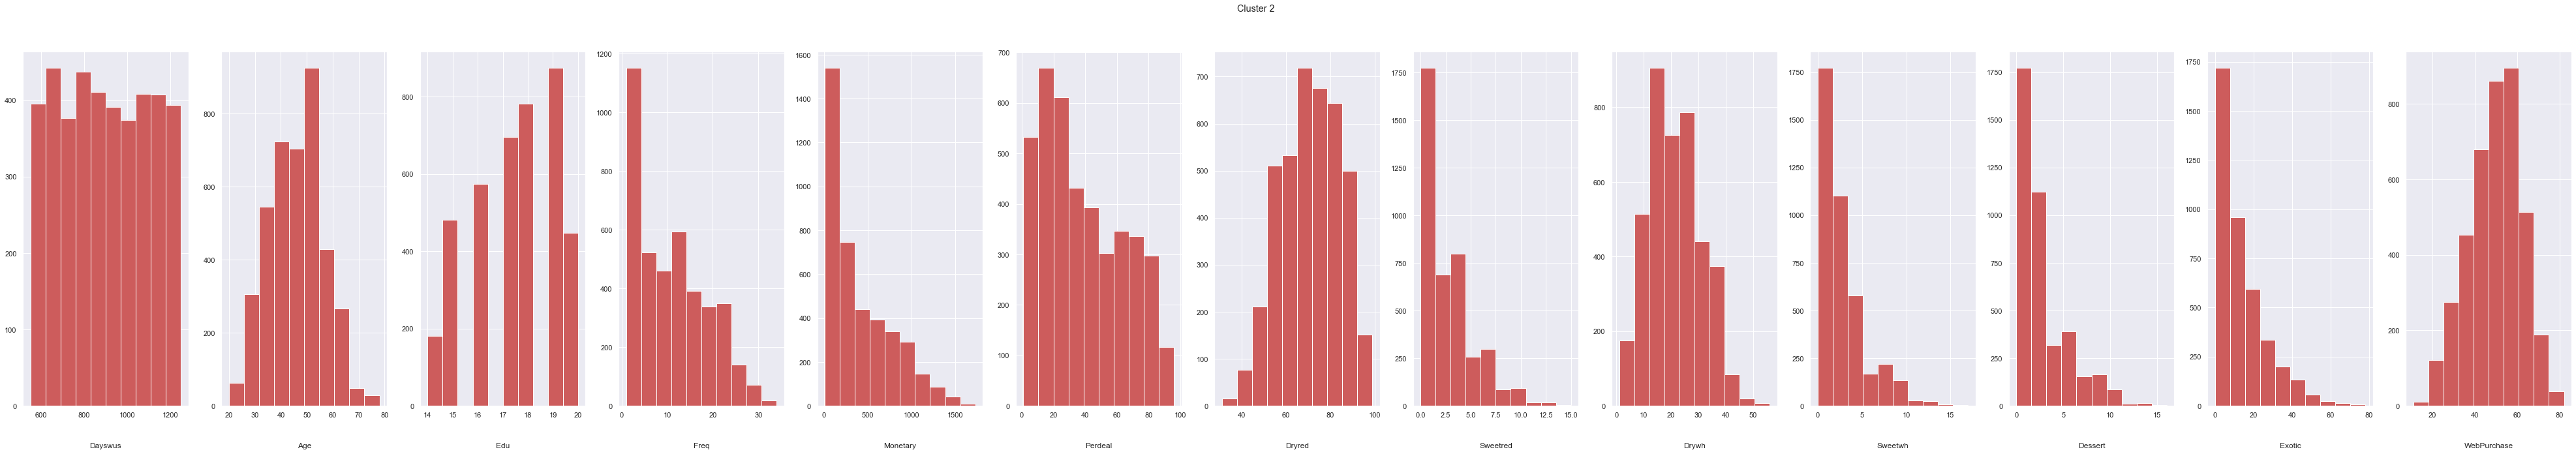

In [296]:
features = wineDf.iloc[:, 0: 13].columns.to_list()

#cluster 0 
merged_df_0 = wineDf[wineDf['merged_labels'] == 0]
# All Numeric Variables' Histograms in one figure
sns.set()
        
# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(1, ceil(len(features) ), figsize=(70, 10))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), features): # Notice the zip() function and flatten() method
    ax.hist(merged_df_0[feat], color='maroon')
    ax.set_title(feat, y=-0.13)
            
# Layout
# Add a centered title to the figure:
title = 'Cluster 0'
plt.suptitle(title)

merged_df_1 = wineDf[wineDf['merged_labels'] == 1]
# All Numeric Variables' Histograms in one figure
sns.set()
        
# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(1, ceil(len(features) ), figsize=(70, 10))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), features): # Notice the zip() function and flatten() method
    ax.hist(merged_df_1[feat], color='firebrick')
    ax.set_title(feat, y=-0.13)
            
# Layout
# Add a centered title to the figure:
title = 'Cluster 1'
plt.suptitle(title)

merged_df_2 = wineDf[wineDf['merged_labels'] == 2]
# All Numeric Variables' Histograms in one figure
sns.set()
        
# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(1, ceil(len(features) ), figsize=(70, 10))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), features): # Notice the zip() function and flatten() method
    ax.hist(merged_df_2[feat], color='indianred')
    ax.set_title(feat, y=-0.13)
            
# Layout
# Add a centered title to the figure:
title = 'Cluster 2'
plt.suptitle(title)
plt.show()



